In [2]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours
from spec_extract import Scale_spectra
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [3]:
galDB = pd.read_pickle('../dataframes/galaxy_database.pkl')
BFs = pd.read_pickle('../dataframes/BF_fit_all.pkl')
lwa = np.load('../data/light_weight_scaling_3.npy')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [84]:
BFs

,bfZ,bfd,bft,bftau,bfz,fields,gids
0,0.003,0.3,5.9,9.00,2.175,GND,23018
1,0.002,0.8,4.6,0.00,1.881,GND,33780
2,0.003,0.5,5.1,0.00,1.616,GSD,42113
3,0.002,0.3,3.4,8.60,1.719,GND,35469
4,0.002,0.4,5.1,8.78,1.625,GSD,41659
5,0.024,0.1,1.6,0.00,1.768,GSD,41148
6,0.030,0.1,5.6,8.70,1.591,GSD,39012
7,0.002,0.4,5.8,8.90,2.239,GND,21516
8,0.003,0.3,5.2,8.70,1.489,GND,21427
9,0.002,0.6,3.6,8.78,1.626,GSD,44824


In [4]:
def Smooth(f,x):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    fx = ksmooth.locpoly(x,f,bandwidth = H)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

In [5]:
def L_nu_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    lam_0 = lam / (1 + z) # restframe wavelenth in angstrom
    dust = 10**(-0.4*Av)
    return ((lam_0**2)/(c * m_star)) * l_aa * dust * 3.839E33

def F_nu_per_M(l_aa, lam, z, Av, m_star):
    conv = 3.086E24 # conversion of Mpc to cm
    D_l = cosmo.luminosity_distance(z).value # in Mpc
    return (1 + z) * L_nu_per_M(l_aa, lam, z, Av, m_star)  / (4 * np.pi * (D_l*conv)**2)

def F_lam_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    return (c / lam**2) * F_nu_per_M(l_aa, lam, z, Av, m_star)

def Get_mass(gwv, gfl, ger, Z, t, z, Av):
    sp = fsps.StellarPopulation(imf_type=1, tpagb_norm_type=0, zcontinuous=1, logzsol=np.log10(Z / 0.019), sfh=0)
    wave,flux=np.array(sp.get_spectrum(tage=t,peraa=True))
    
    fl_m = F_lam_per_M(flux, wave * (1 + z), z, Av, sp.stellar_mass)
    
    IDX = [U for U in range(len(gwv)) if 8000 < gwv[U] < 11300]
    return np.log10(Scale_model(gfl[IDX],ger[IDX],interp1d(wv,fl_m)(gwv[IDX])))

data_path = '../data/'
model_path = hpath + 'fsps_models_for_fit/fsps_spec/'
chi_path = '../chidat/'
spec_path = '../spec_files/'
beam_path = '../beams/'
template_path = '../templates/'
out_path = '../data/posteriors/'
phot_path = '../phot/'

"""
FUNCTIONS:
-Calzetti_low
-Calzetti_hi
-Calzetti

CLASSES:
-Gen_spec
--Sim_spec_indv
--Sim_spec_mult
--Sim_spec_mult_point
--Sim_spec
--Sim_phot_mult
--Sim_phot
--Sim_all
"""


def Calzetti_low(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    cal = 10**(-0.4*k*Av/Rv)
    return cal

def Calzetti_hi(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-1.857 +1.04/(lam)) + Rv
    cal = 10**(-0.4*k*Av/Rv)    
    
    return cal

def Calzetti(Av,lam):
    dust = Calzetti_low(Av,lam)
    dust2 = Calzetti_hi(Av,lam)
    
    for ii in range(len(dust)):
        if lam[ii] > 6300:
            dust[ii]=dust2[ii] 
    
    return dust

# How to mass scale

### step 1: convert best fit model F$_\lambda$ / M$_\odot$ (unscaled model)

### step 2: generate photometry model using unscaled model

### step 3: use photometry and unscaled forward model to get mass of galaxy (mass scale) 

### step 4: scale model

### step 5: use scaled model to scale g102 and g141 data

In [21]:
idx = 22

sp1 = Gen_spec(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0], g102_lims=[8500,11300])      

sp2 = Gen_spec2(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0], g102_lims=[8500,11300]) 

sp3 = Gen_spec3(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0], g102_lims=[8500,11300]) 

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [56]:
def Chi_squared(D, M, sig):
    return np.sum(((D-M)/sig)**2)

def P(F,x):
    return np.exp(-np.array(F) / 2) / np.trapz(np.exp(-np.array(F) / 2),x)

In [193]:
bftau = np.array(tau)[np.round(ult,1) == np.round(galDB['taux'][idx],1)][0]

LWA = lwa[metal == galDB.Z[idx]].T[tau == bftau][0].T[0].T
mt = age[np.round(LWA,1) == galDB.t[idx]][0] 

if bftau == 0.0:
    mtau = int(0)
else:
    mtau = bftau

sp3.Scale_flux(0.024, 1.6, 0, 1.608, 0.1)
# sp1.Sim_all(galDB.Z[idx], 0.5, mtau, Av=galDB.dx[idx])

# sp1.Bflx, sp2.Berr, sp2.Rflx, sp2.Rerr = Scale_spectra(sp2.Bwv,sp2.Bflx,sp2.Berr,sp2.Rwv,sp2.Rflx,sp2.Rerr,sp2.Pwv,sp2.Pflx) 

# sp1.Sim_all(galDB.Z[idx], 0.5, mtau, Av=galDB.dx[idx])

In [189]:
galDB.ids[22]

41520

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


653.6493788172689
653.4373571233571
653.4820911122199


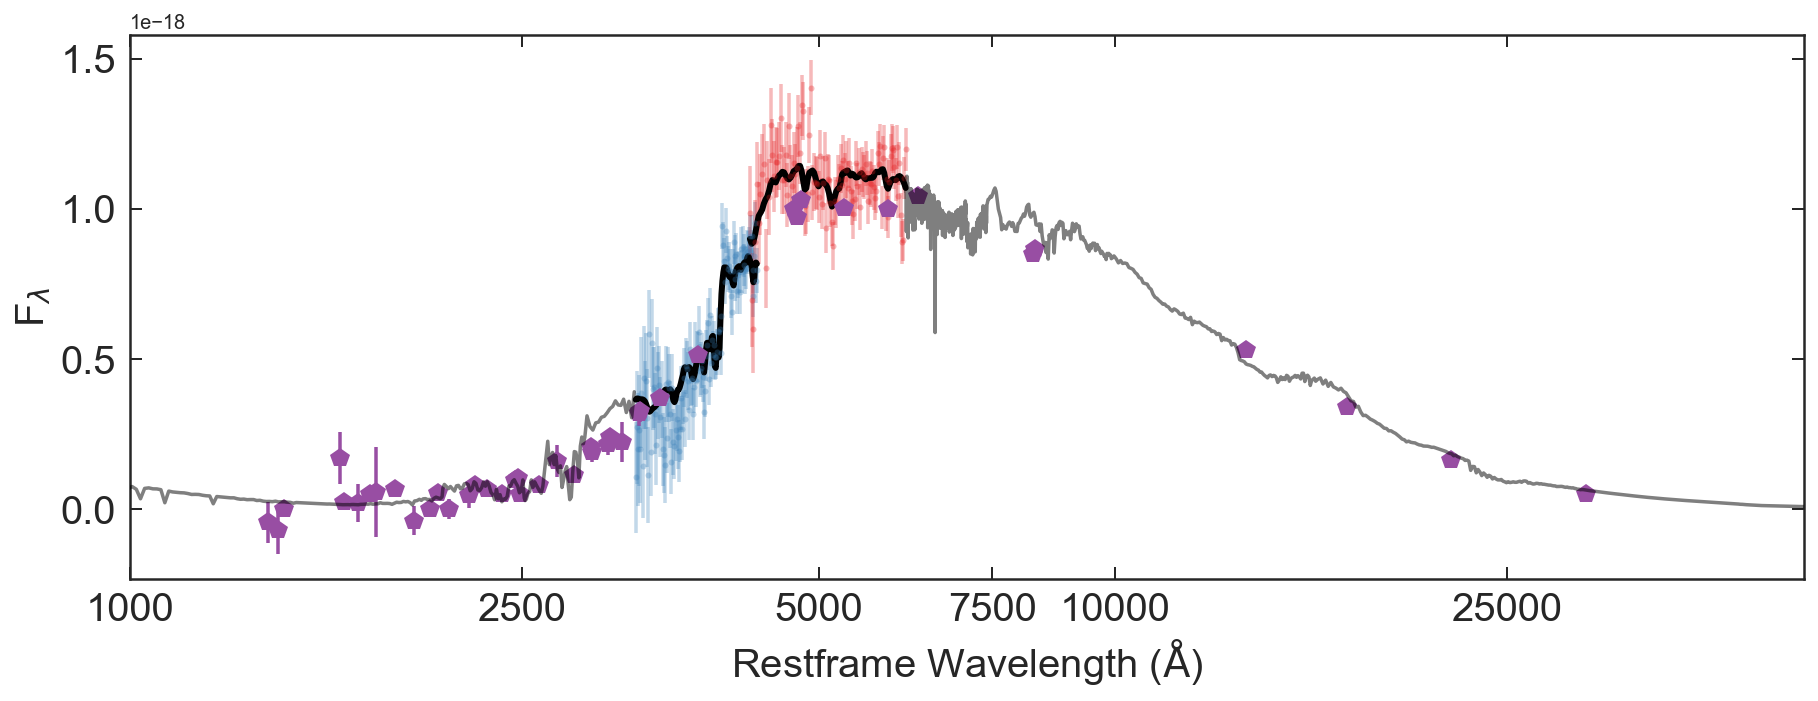

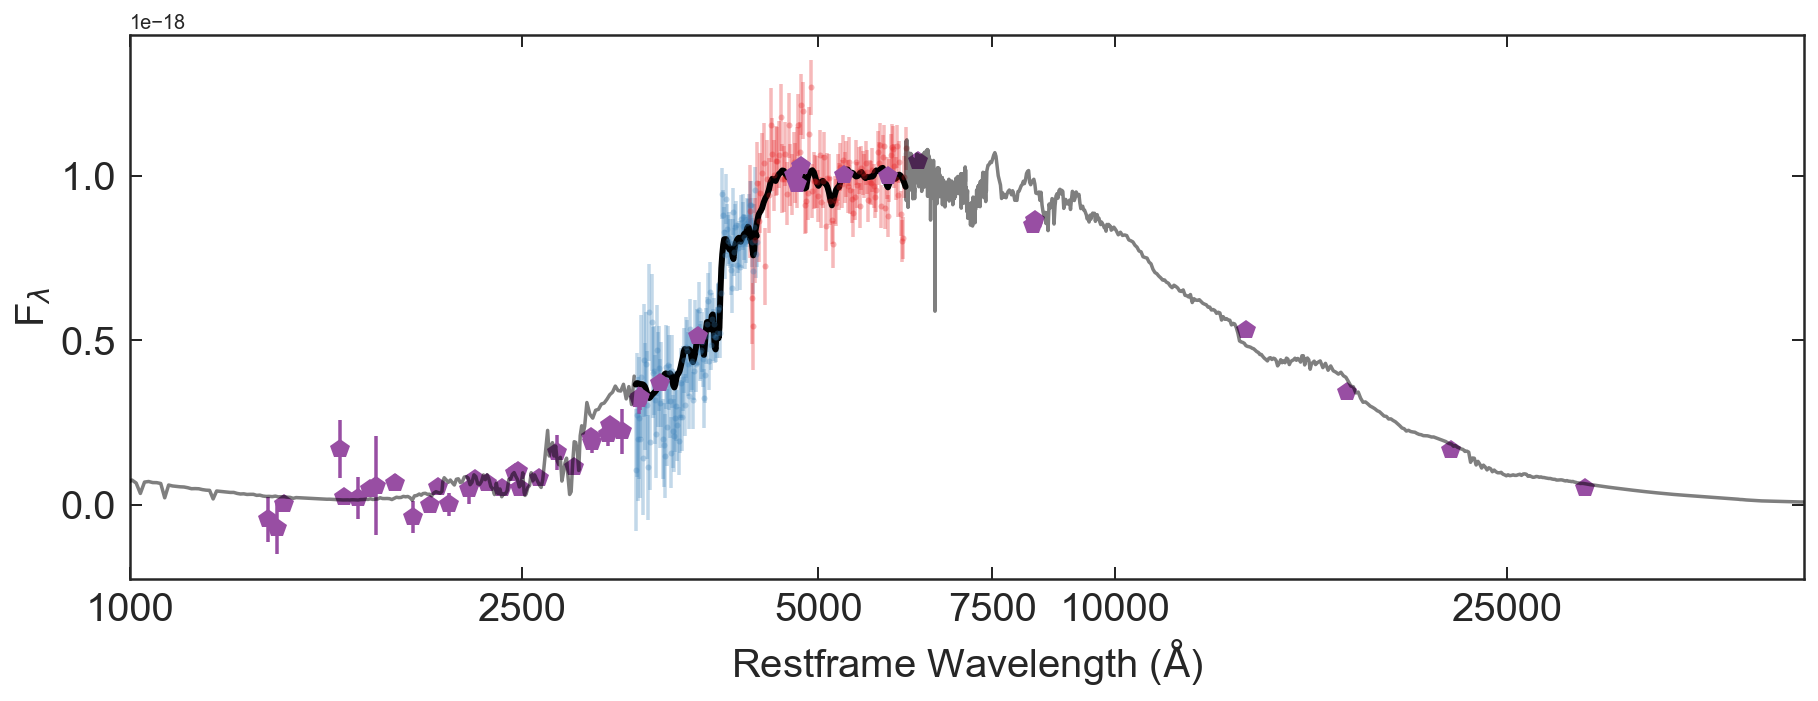

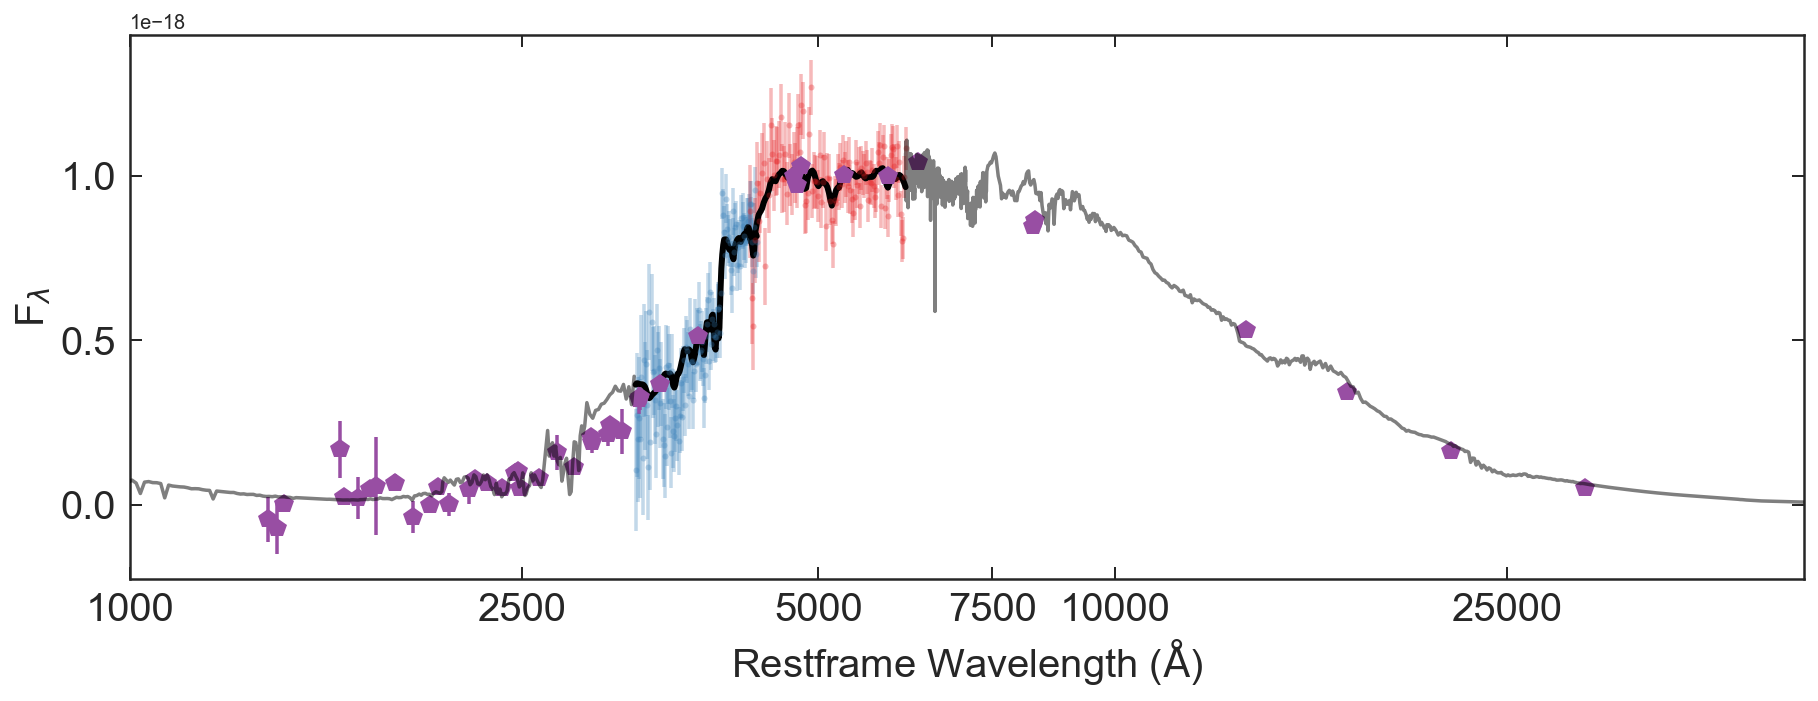

In [194]:
sp1.Sim_all(0.024, 1.6, 0, Av=galDB.dx[idx])
sp2.Sim_all(0.024, 1.6, 0, Av=galDB.dx[idx])
sp3.Sim_all(0.024, 1.6, 0, Av=galDB.dx[idx])

wv,fl = np.load('/Users/vestrada/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(0.024, 1.6, 0))

plt.figure(figsize=[15,5])
plt.errorbar(np.log10(sp1.Bwv_rf),sp1.Bflx,sp1.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(sp1.Rwv_rf),sp1.Rflx,sp1.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

plt.errorbar(np.log10(sp1.Pwv_rf),sp1.Pflx,sp1.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(sp1.Bwv_rf),sp1.Bmfl,'k',linewidth=3)
plt.plot(np.log10(sp1.Rwv_rf),sp1.Rmfl,'k',linewidth=3)


IDb = [U for U in range(len(wv)) if wv[U] < sp1.Bwv_rf[0]]
IDr = [U for U in range(len(wv)) if wv[U] > sp1.Rwv_rf[-1]]

plt.plot(np.log10(wv[IDb]),sp1.PC * fl[IDb],'k',ms=10,zorder =5,alpha=0.5)
plt.plot(np.log10(wv[IDr]),sp1.PC * fl[IDr],'k',ms=10,zorder =5,alpha=0.5)

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)


plt.figure(figsize=[15,5])
plt.errorbar(np.log10(sp2.Bwv_rf),sp2.Bflx,sp2.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(sp2.Rwv_rf),sp2.Rflx,sp2.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

plt.errorbar(np.log10(sp2.Pwv_rf),sp2.Pflx,sp2.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(sp2.Bwv_rf),sp2.Bmfl,'k',linewidth=3)
plt.plot(np.log10(sp2.Rwv_rf),sp2.Rmfl,'k',linewidth=3)

IDb = [U for U in range(len(wv)) if wv[U] < sp2.Bwv_rf[0]]
IDr = [U for U in range(len(wv)) if wv[U] > sp2.Rwv_rf[-1]]

plt.plot(np.log10(wv[IDb]),sp2.PC * fl[IDb],'k',ms=10,zorder =5,alpha=0.5)
plt.plot(np.log10(wv[IDr]),sp2.PC * fl[IDr],'k',ms=10,zorder =5,alpha=0.5)

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.figure(figsize=[15,5])
plt.errorbar(np.log10(sp3.Bwv_rf),sp3.Bflx,sp3.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(sp3.Rwv_rf),sp3.Rflx,sp3.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

plt.errorbar(np.log10(sp3.Pwv_rf),sp3.Pflx,sp3.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(sp3.Bwv_rf),sp3.Bmfl,'k',linewidth=3)
plt.plot(np.log10(sp3.Rwv_rf),sp3.Rmfl,'k',linewidth=3)

IDb = [U for U in range(len(wv)) if wv[U] < sp3.Bwv_rf[0]]
IDr = [U for U in range(len(wv)) if wv[U] > sp3.Rwv_rf[-1]]

plt.plot(np.log10(wv[IDb]),sp3.PC * fl[IDb],'k',ms=10,zorder =5,alpha=0.5)
plt.plot(np.log10(wv[IDr]),sp3.PC * fl[IDr],'k',ms=10,zorder =5,alpha=0.5)

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

print((Chi_square(sp1.Bflx, sp1.Bmfl, sp1.Berr ) + Chi_square(sp1.Rflx, sp1.Rmfl, sp1.Rerr) +
       Chi_square(sp1.Pflx, sp1.Pmfl, sp1.Perr )))

print((Chi_square(sp2.Bflx, sp2.Bmfl, sp2.Berr ) + Chi_square(sp2.Rflx, sp2.Rmfl, sp2.Rerr) +
       Chi_square(sp2.Pflx, sp2.Pmfl, sp2.Perr )))

print((Chi_square(sp3.Bflx, sp3.Bmfl, sp3.Berr ) + Chi_square(sp3.Rflx, sp3.Rmfl, sp3.Rerr) +
       Chi_square(sp3.Pflx, sp3.Pmfl, sp3.Perr )))

In [180]:
chi1 = []
chi2 = []
chi3 = []

for i in range(len(age)):
    sp1.Sim_all(0.024, age[i], 0, Av=0.1)
    sp2.Sim_all(0.024, age[i], 0, Av=0.1)
    sp3.Sim_all(0.024, age[i], 0, Av=0.1)

    chi1.append((Chi_square(sp1.Bflx, sp1.Bmfl, sp1.Berr ) + Chi_square(sp1.Rflx, sp1.Rmfl, sp1.Rerr) +
           Chi_square(sp1.Pflx, sp1.Pmfl, sp1.Perr )))

    chi2.append((Chi_square(sp2.Bflx, sp2.Bmfl, sp2.Berr ) + Chi_square(sp2.Rflx, sp2.Rmfl, sp2.Rerr) +
           Chi_square(sp2.Pflx, sp2.Pmfl, sp2.Perr )))
    
    chi3.append((Chi_square(sp3.Bflx, sp3.Bmfl, sp3.Berr ) + Chi_square(sp3.Rflx, sp3.Rmfl, sp3.Rerr) +
           Chi_square(sp3.Pflx, sp3.Pmfl, sp3.Perr )))

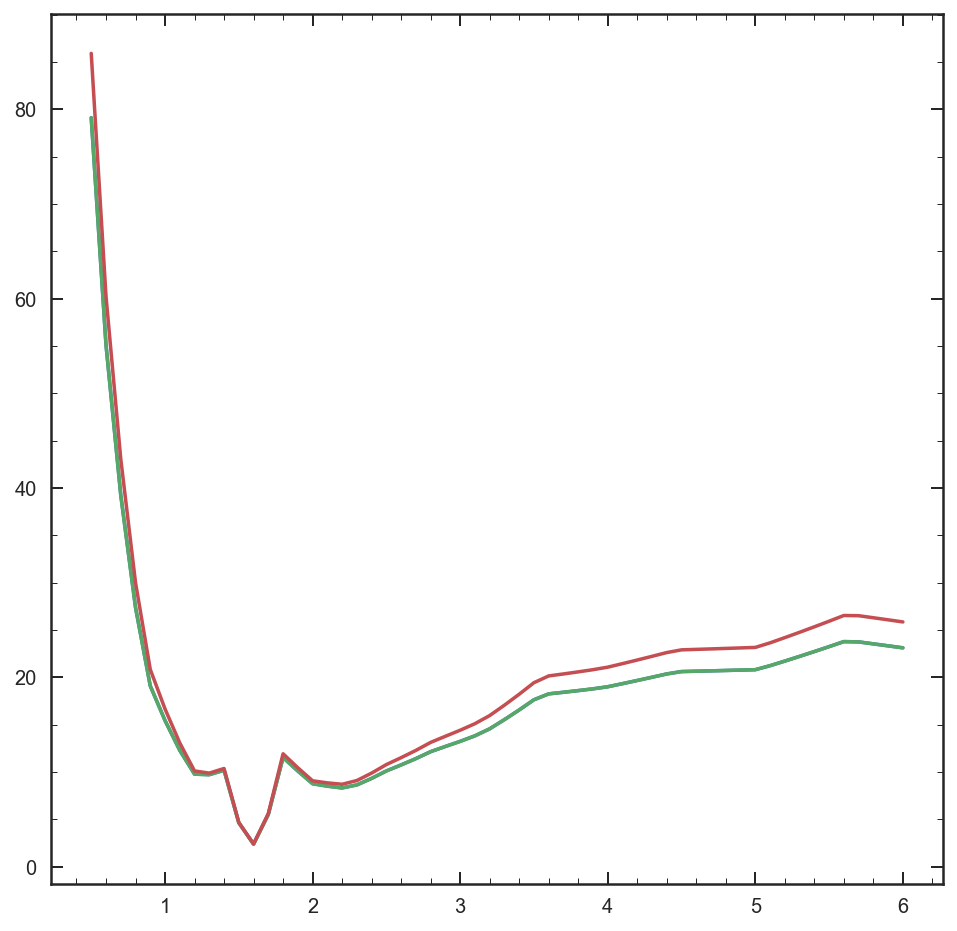

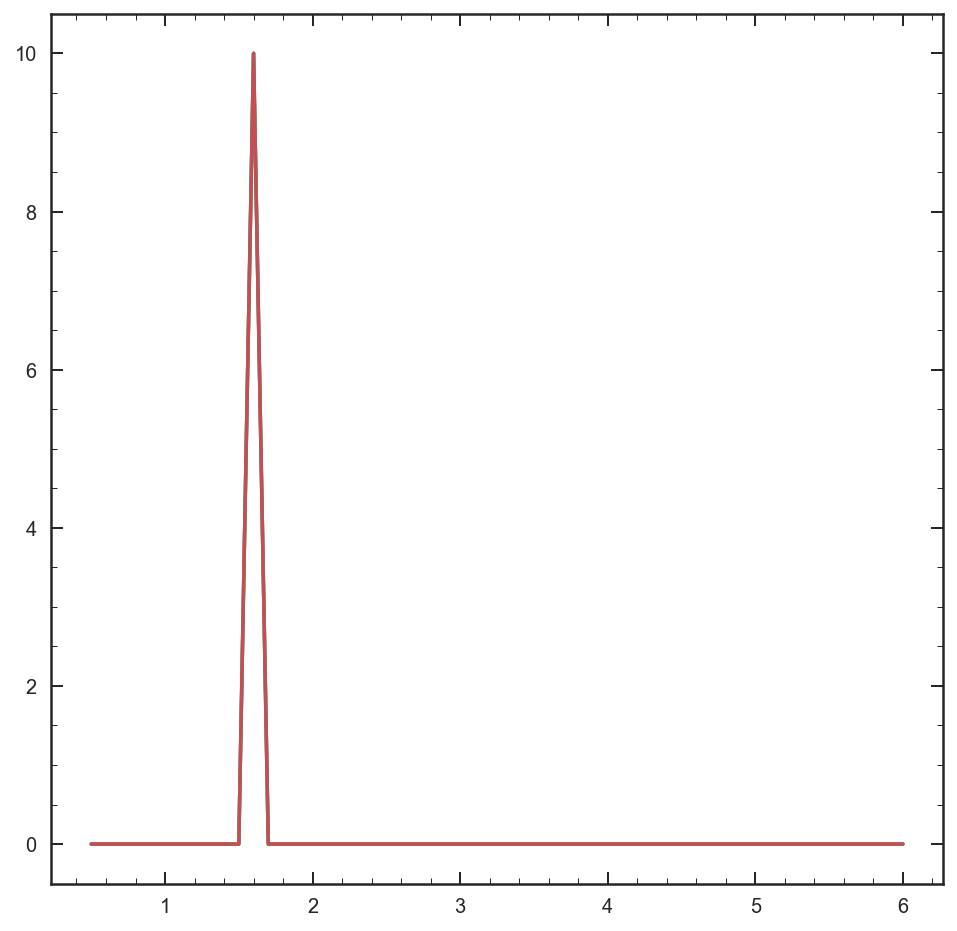

In [181]:
plt.figure(figsize=[8,8])
plt.plot(age,np.array(chi1) / (len(Bflx) + len(Rflx) + len(sp1.Pflx)) )
plt.plot(age,np.array(chi2) / (len(Bflx) + len(Rflx) + len(sp1.Pflx)) )
plt.plot(age,np.array(chi3) / (len(Bflx) + len(Rflx) + len(sp1.Pflx)) )

plt.figure(figsize=[8,8])
plt.plot(age,P(chi1,age))
plt.plot(age,P(chi2,age))
plt.plot(age,P(chi3,age))

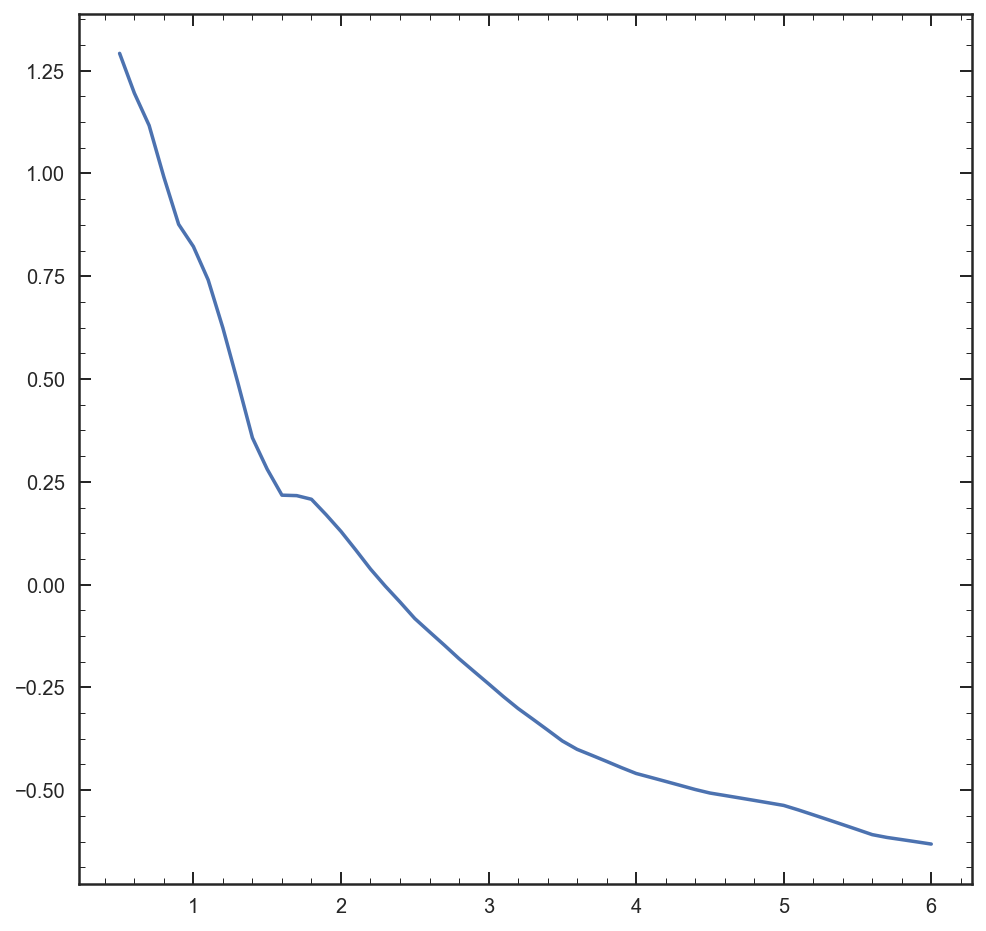

In [182]:
plt.figure(figsize=[8,8])
plt.plot(age,np.array(chi1)-np.array(chi2))
# plt.plot(age,chi2)

In [8]:
sp = fsps.StellarPopulation(imf_type=1, tpagb_norm_type=0, zcontinuous=1, logzsol=np.log10(0.019 / 0.019), sfh=0)
sp2 = fsps.StellarPopulation(imf_type=0, tpagb_norm_type=0, zcontinuous=1, logzsol=np.log10(0.019 / 0.019), sfh=0)


In [11]:
wave,flux=sp.get_spectrum(tage=0.5,peraa=True)
wave2,flux2=sp2.get_spectrum(tage=0.5,peraa=True)

In [82]:
plt.figure(figsize=[10,5])
plt.plot(sp1.model_wave[sp1.model_wave < 150000], Smooth(sp1.S_model_flux[sp1.model_wave < 150000],sp1.model_wave[sp1.model_wave < 150000]))
plt.xlim(3000,6000)

AttributeError: 'Gen_spec' object has no attribute 'model_wave'

<Figure size 720x360 with 0 Axes>

In [104]:
# plt.figure(figsize=[10,5])

bfz = 1.608
red_chi = []

for i in range(len(age)):
    wv,fl = np.load('/Users/vestrada/fsps_models_for_fit/fsps_spec/m0.019_a{0}_dt0_spec.npy'.format(age[i]))

    US_model_flux = F_lam_per_M(fl, wv * (1 + bfz), bfz, 0, 1)

    US_pwv, US_pfl = sp1.Sim_phot_mult(wv * (1 + bfz), US_model_flux)

    mass = Scale_model(sp1.Pflx, sp1.Perr, US_pfl)

    S_model_flux = US_model_flux * mass

    Bw,Bf = sp1.Sim_spec_indv(sp1.Bbeam, wv * (1 + bfz), S_model_flux)
    Rw,Rf = sp1.Sim_spec_indv(sp1.Rbeam, wv * (1 + bfz), S_model_flux)

    iBmf = interp1d(Bw,Bf)(sp1.Bwv)       
    iRmf = interp1d(Rw,Rf)(sp1.Rwv)  

    Bmfl = iBmf / sp1.Btrans
    Rmfl = iRmf / sp1.Rtrans

    Bscale = Scale_model(sp1.Bflx, sp1.Berr, Bmfl)
    Rscale = Scale_model(sp1.Rflx, sp1.Rerr, Rmfl)

    Bflx = sp1.Bflx / Bscale ; Berr = sp1.Berr / Bscale 
    Rflx = sp1.Rflx / Rscale ; Rerr = sp1.Rerr / Rscale 

    red_chi.append((Chi_square(Bflx, Bmfl, Berr ) + 
                    Chi_square(Rflx, Rmfl, Rerr) + Chi_square(sp1.Pflx, US_pfl * mass, sp1.Perr ))  / (len(Bflx) + len(Rflx) + len(sp1.Pflx)))


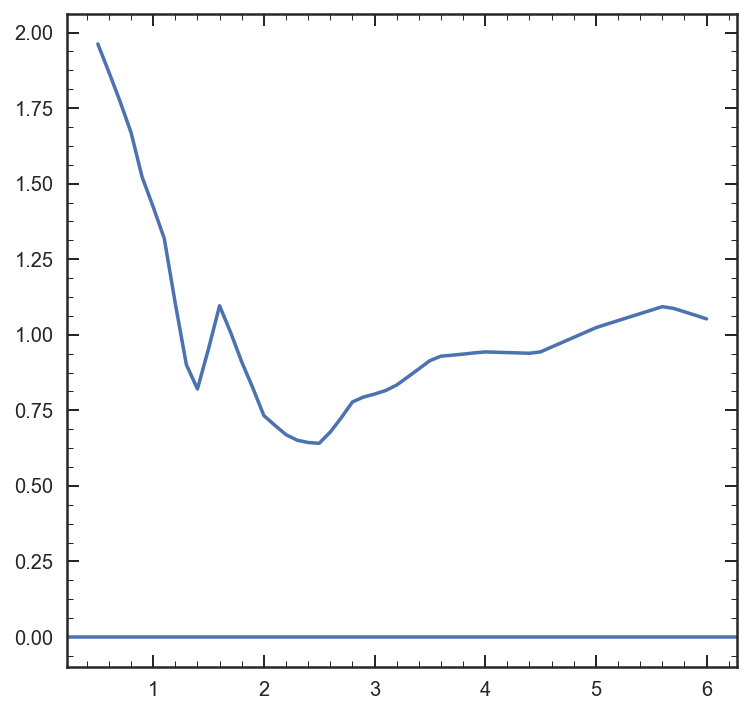

In [105]:
plt.figure(figsize=[6,6])
plt.plot(age,np.log10(red_chi))
plt.axhline(0)

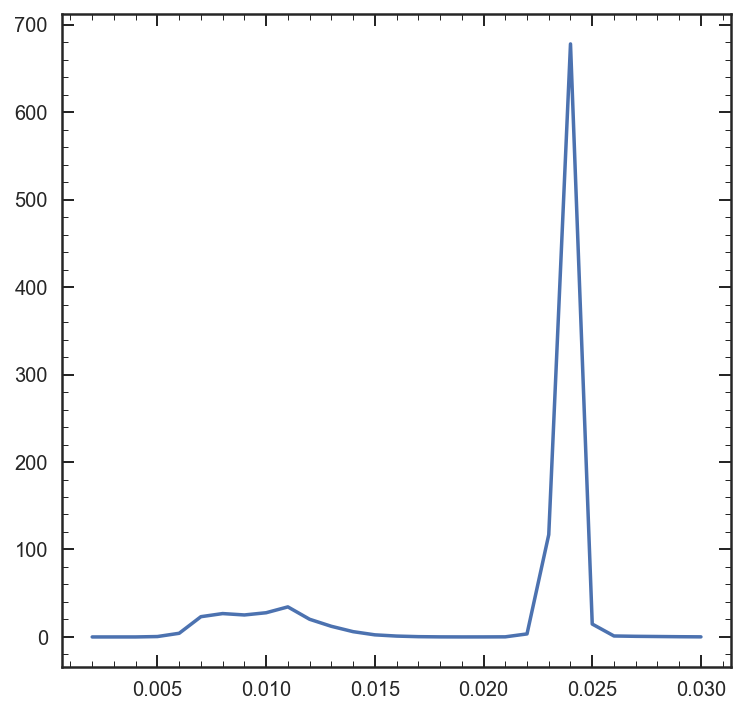

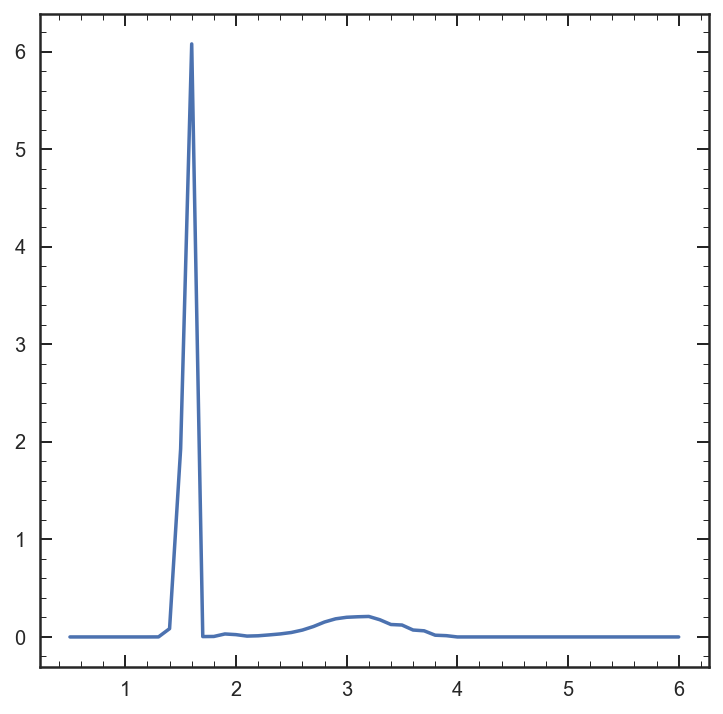

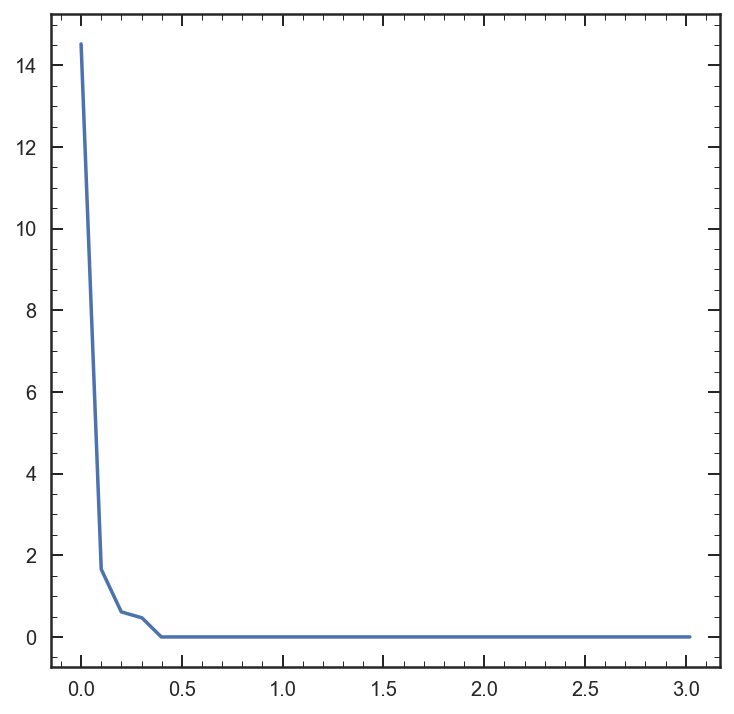

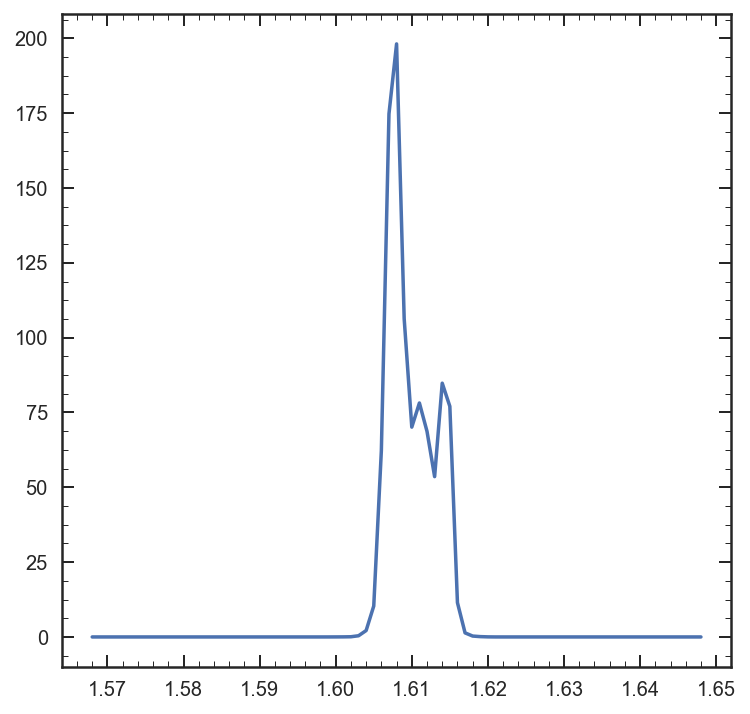

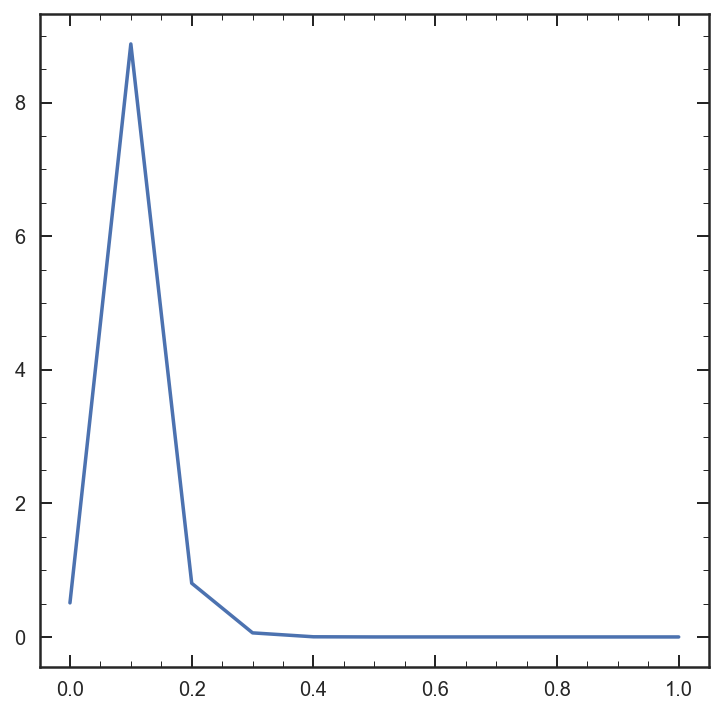

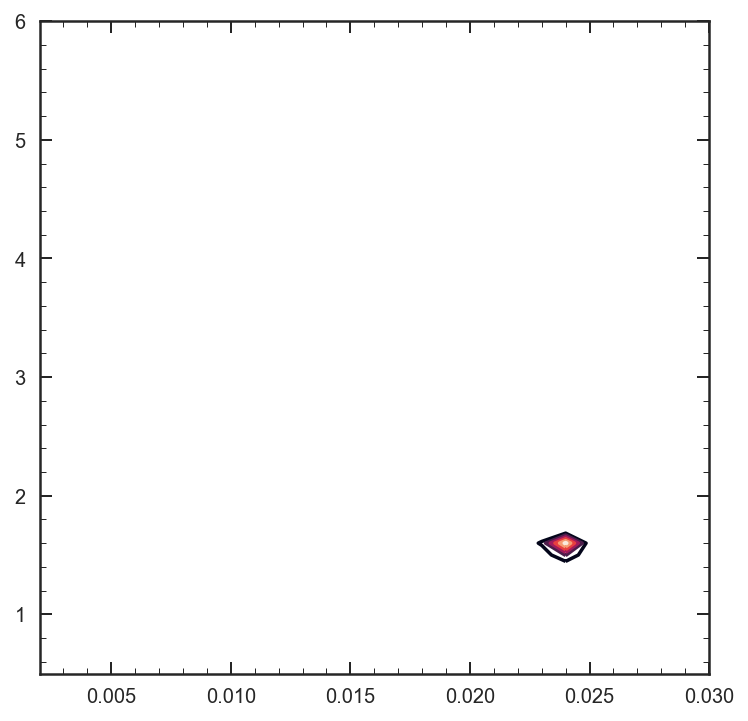

In [14]:
P = np.load('../data/posteriors/fit_all_GSD_41520_tZ_pos.npy')
Z,PZ = np.load('../data/posteriors/fit_all_GSD_41520_Z_pos.npy')
t,Pt = np.load('../data/posteriors/fit_all_GSD_41520_t_pos.npy')
ultau,Ptau = np.load('../data/posteriors/fit_all_GSD_41520_tau_pos.npy')
z,Pz = np.load('../data/posteriors/fit_all_GSD_41520_rs_pos.npy')
d,Pd = np.load('../data/posteriors/fit_all_GSD_41520_d_pos.npy')


plt.figure(figsize=[6,6])
plt.plot(Z,PZ)

plt.figure(figsize=[6,6])
plt.plot(t,Pt)

plt.figure(figsize=[6,6])
plt.plot(ultau,Ptau)

plt.figure(figsize=[6,6])
plt.plot(z,Pz)

plt.figure(figsize=[6,6])
plt.plot(d,Pd)

plt.figure(figsize=[6,6])
plt.contour(M,A,P)

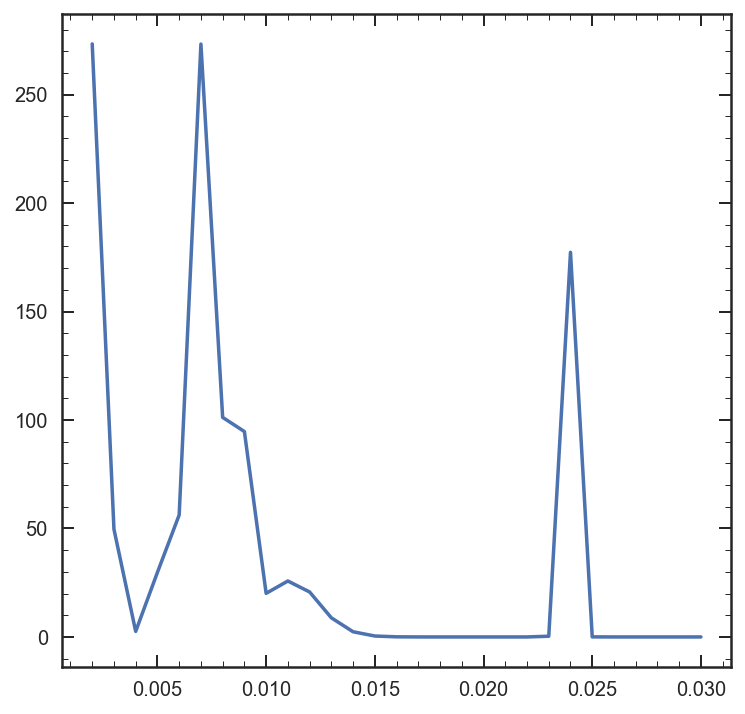

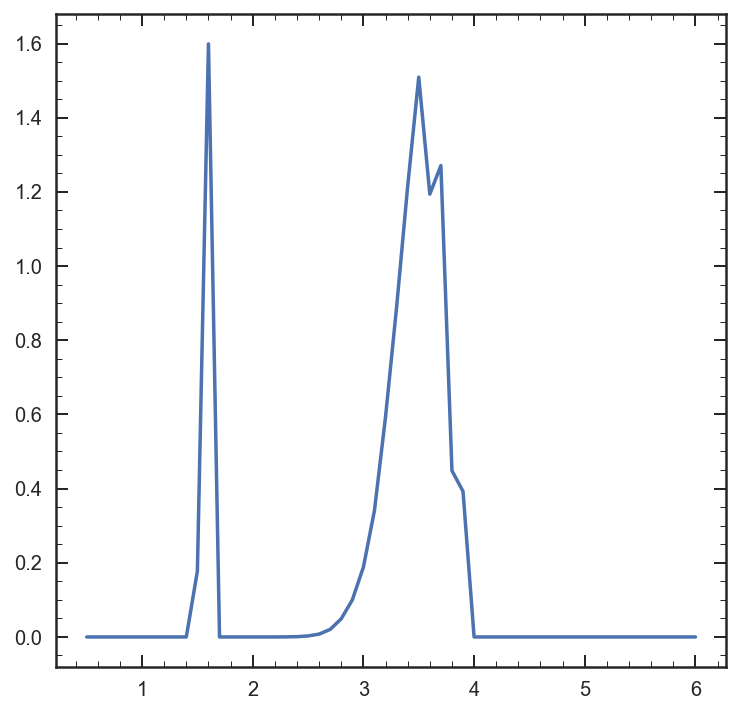

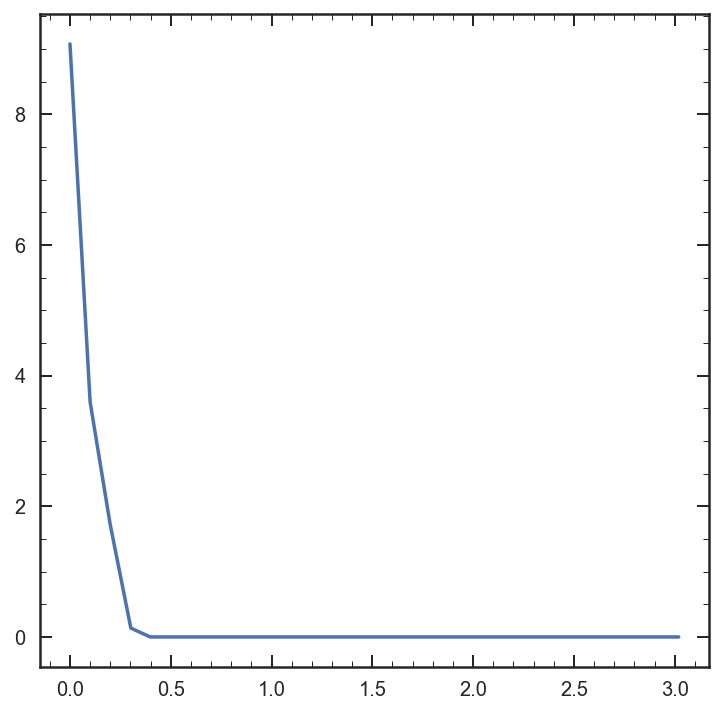

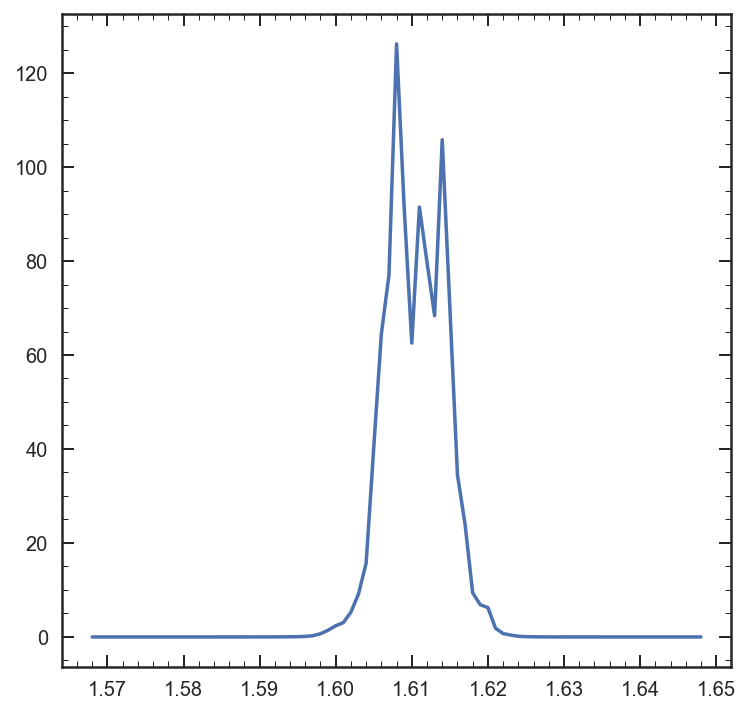

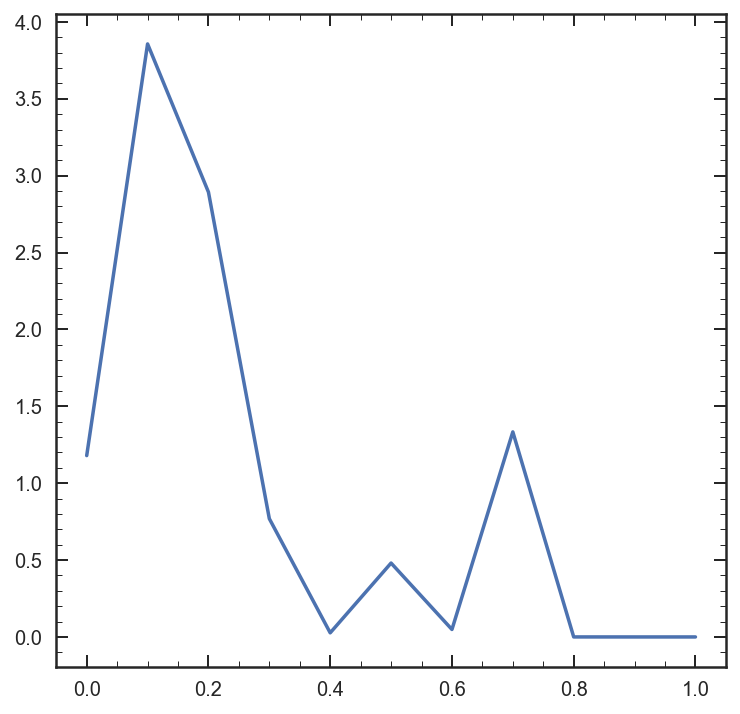

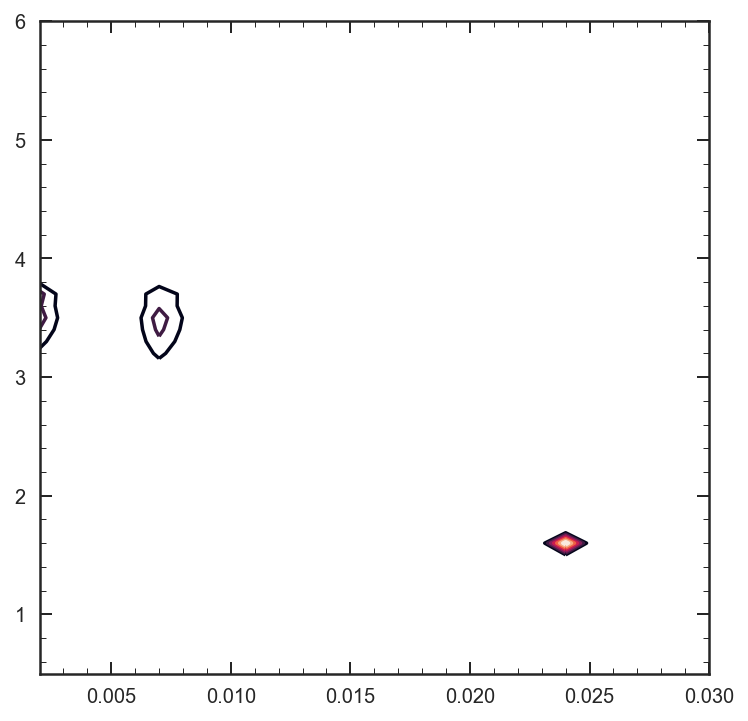

In [253]:
mtest = np.round(np.arange(0.002,0.031,0.008),3)

P = np.load('../data/posteriors/fit_all_2_GSD_41520_tZ_pos.npy')
Z,PZ = np.load('../data/posteriors/fit_all_2_GSD_41520_Z_pos.npy')
t,Pt = np.load('../data/posteriors/fit_all_2_GSD_41520_t_pos.npy')
ultau,Ptau = np.load('../data/posteriors/fit_all_2_GSD_41520_tau_pos.npy')
z,Pz = np.load('../data/posteriors/fit_all_2_GSD_41520_rs_pos.npy')
d,Pd = np.load('../data/posteriors/fit_all_2_GSD_41520_d_pos.npy')

plt.figure(figsize=[6,6])
plt.plot(Z,PZ)

plt.figure(figsize=[6,6])
plt.plot(t,Pt)

plt.figure(figsize=[6,6])
plt.plot(ultau,Ptau)

plt.figure(figsize=[6,6])
plt.plot(z,Pz)

plt.figure(figsize=[6,6])
plt.plot(d,Pd)

plt.figure(figsize=[6,6])
plt.contour(M,A,P)

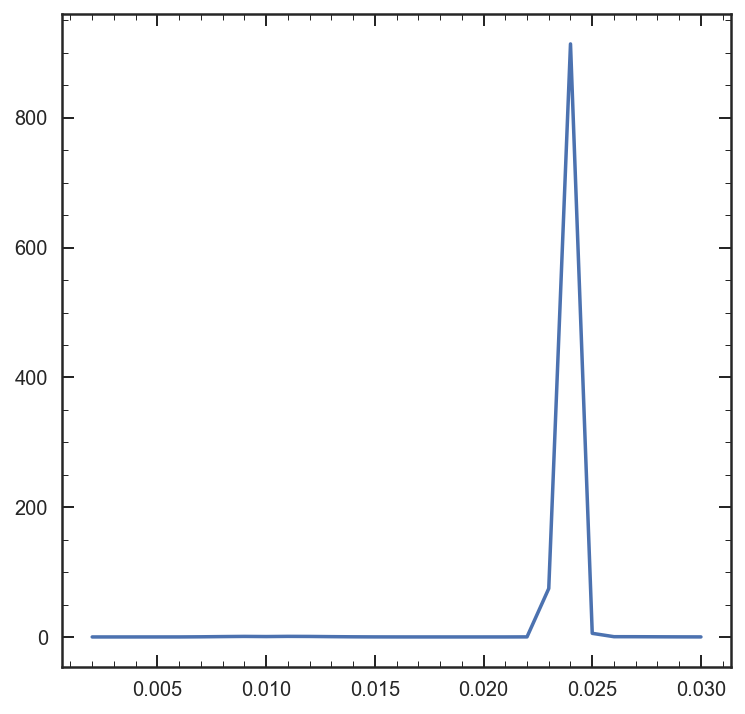

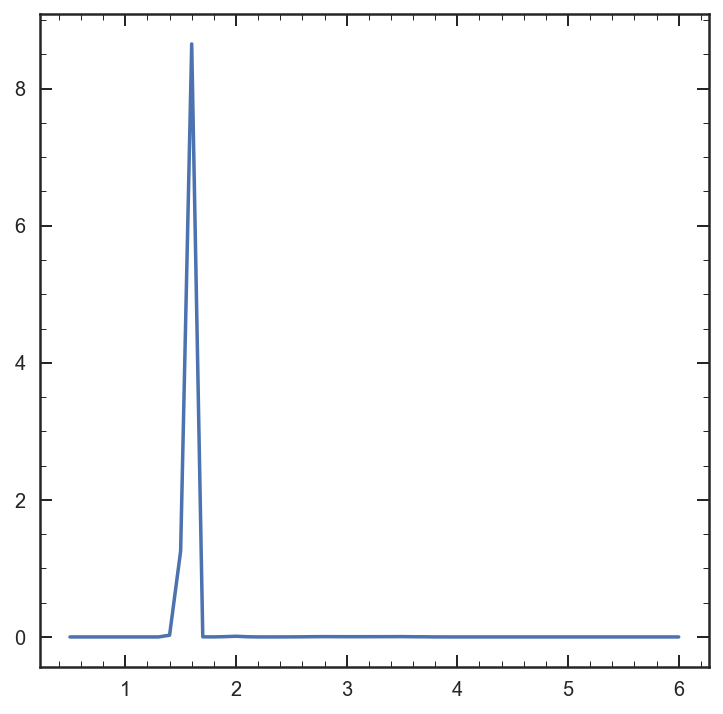

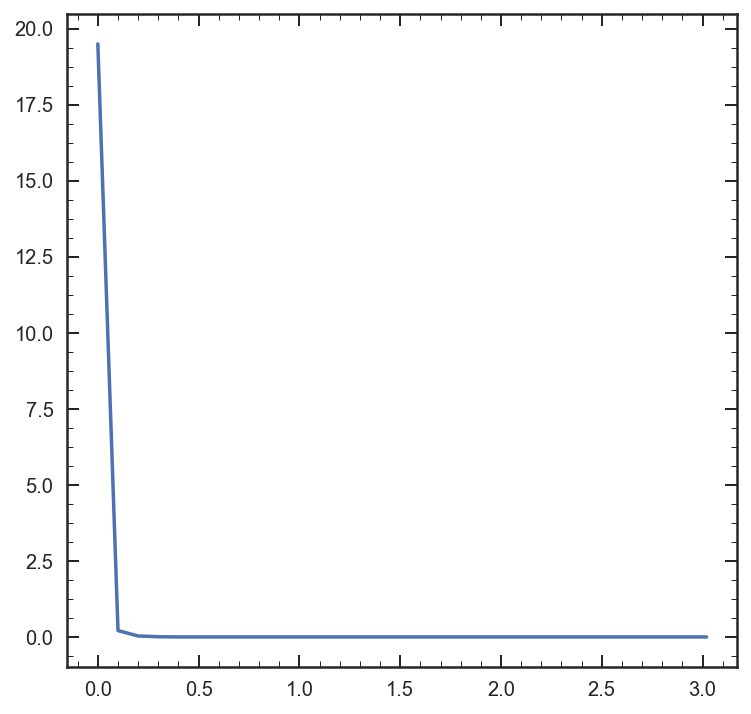

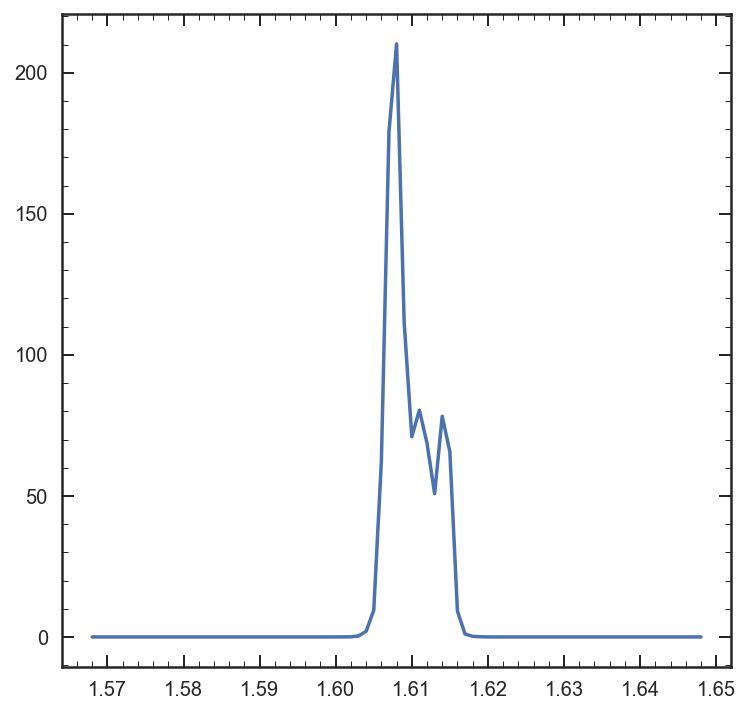

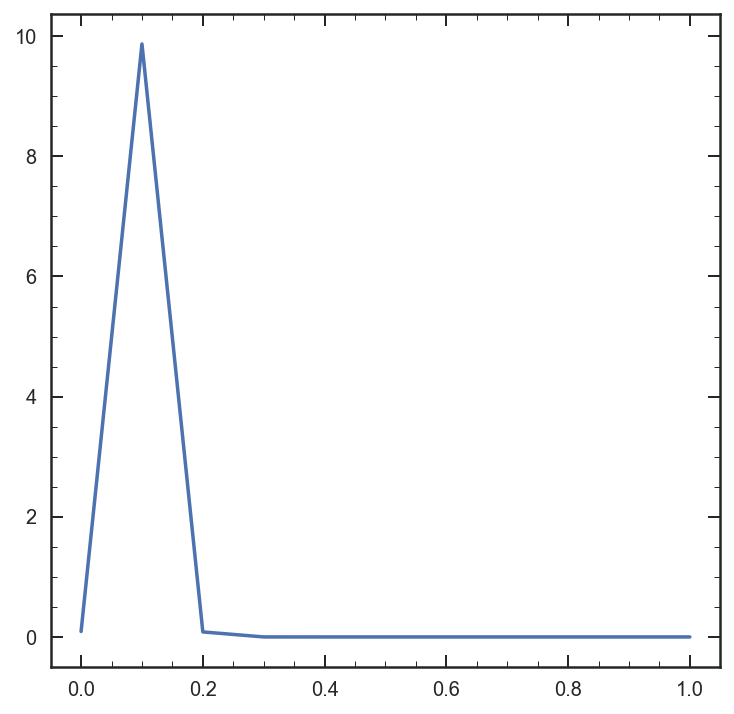

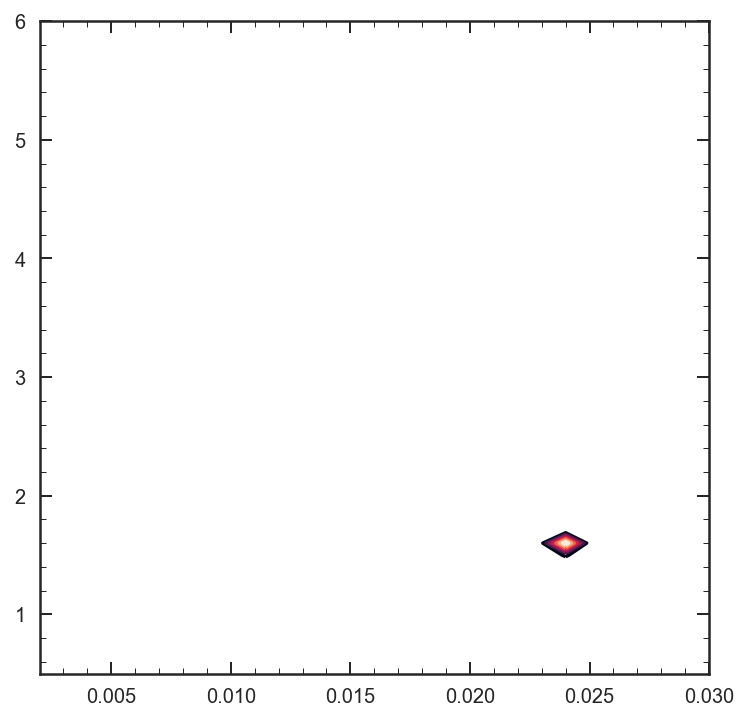

In [16]:
P = np.load('../data/posteriors/fit_all_3_GSD_41520_tZ_pos.npy')
Z,PZ = np.load('../data/posteriors/fit_all_3_GSD_41520_Z_pos.npy')
t,Pt = np.load('../data/posteriors/fit_all_3_GSD_41520_t_pos.npy')
ultau,Ptau = np.load('../data/posteriors/fit_all_3_GSD_41520_tau_pos.npy')
z,Pz = np.load('../data/posteriors/fit_all_3_GSD_41520_rs_pos.npy')
d,Pd = np.load('../data/posteriors/fit_all_3_GSD_41520_d_pos.npy')


plt.figure(figsize=[6,6])
plt.plot(Z,PZ)

plt.figure(figsize=[6,6])
plt.plot(t,Pt)

plt.figure(figsize=[6,6])
plt.plot(ultau,Ptau)

plt.figure(figsize=[6,6])
plt.plot(z,Pz)

plt.figure(figsize=[6,6])
plt.plot(d,Pd)

plt.figure(figsize=[6,6])
plt.contour(M,A,P)

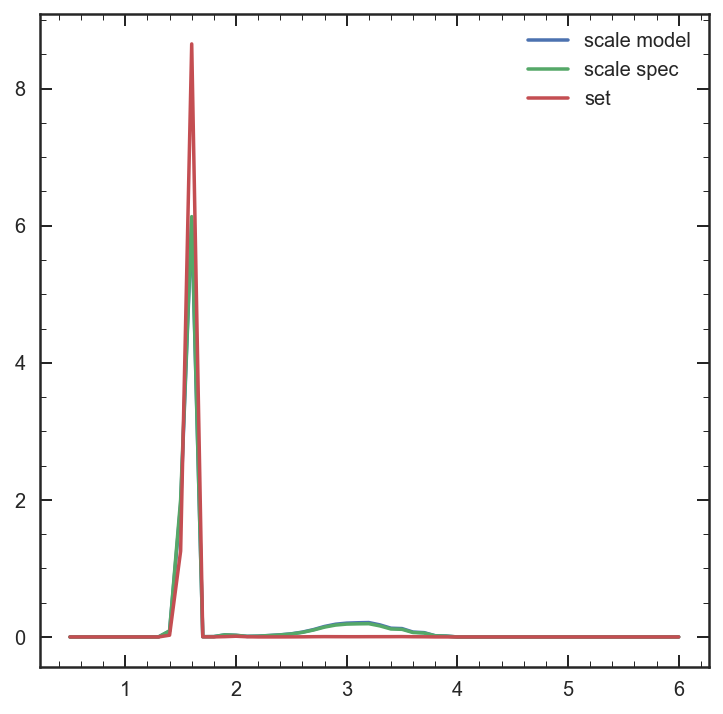

In [17]:
mtest = np.round(np.arange(0.002,0.031,0.008),3)

x1, P1 = np.load('../data/posteriors/fit_all_GSD_41520_t_pos.npy')
x2, P2 = np.load('../data/posteriors/fit_all_2_GSD_41520_t_pos.npy')
x3, P3 = np.load('../data/posteriors/fit_all_3_GSD_41520_t_pos.npy')

plt.figure(figsize=[6,6])
plt.plot(x1,P1, label='scale model')
plt.plot(x2,P2, label='scale spec')
plt.plot(x3,P3, label='set')
plt.legend()

In [223]:
from C_full_fit import Stich_grids
z = [1.6,1.606,1.61]

def Best_fit_model(name, metal, age, tau, rshift, dust = np.arange(0,1.1,.1)):
    chi = np.zeros([len(dust),len(metal),len(age),len(tau),len(rshift)])
    instr = ['g102','g141','phot']

    for ii in instr:
        chifiles = ['../chidat/{0}_d{1}_{2}_chidata.npy'.format(name, U, ii) for U in range(len(dust))]
        chi += Stich_grids(chifiles)

    x = np.argwhere(chi == np.min(chi))[0]

    return dust[x[0]],metal[x[1]], age[x[2]], tau[x[3]],rshift[x[4]]

In [224]:
Best_fit_model('fit_test_GSD_41520',mtest,age,tau,z)

(0.1, 0.01, 4.8, 8.6, 1.606)

In [225]:
Best_fit_model('fit_test2_GSD_41520',mtest,age,tau,z)

(0.0, 0.01, 6.0, 0, 1.606)

In [233]:
Best_fit_model('fit_test3_GSD_41520',mtest,age,tau,z)

(0.0, 0.026, 2.4, 8.3, 1.6100000000000000977)

In [126]:
from C_full_fit import Gen_spec2

In [127]:
idx = 22

sp1 = Gen_spec2(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0], g102_lims=[8500,11300],tmp_err=True, phot_errterm = 0.03)      



/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [26]:
galDB.ids[22]

41520

In [121]:
BFs

,bfZ,bfd,bft,bftau,bfz,fields,gids
0,0.003,0.3,5.9,9.00,2.175,GND,23018
1,0.002,0.8,4.6,0.00,1.881,GND,33780
2,0.003,0.5,5.1,0.00,1.616,GSD,42113
3,0.002,0.3,3.4,8.60,1.719,GND,35469
4,0.002,0.4,5.1,8.78,1.625,GSD,41659
5,0.024,0.1,1.6,0.00,1.768,GSD,41148
6,0.030,0.1,5.6,8.70,1.591,GSD,39012
7,0.002,0.4,5.8,8.90,2.239,GND,21516
8,0.003,0.3,5.2,8.70,1.489,GND,21427
9,0.002,0.6,3.6,8.78,1.626,GSD,44824


In [132]:
sp1.Sim_all(0.024, 1.6, 0, 1.608, 0.1)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


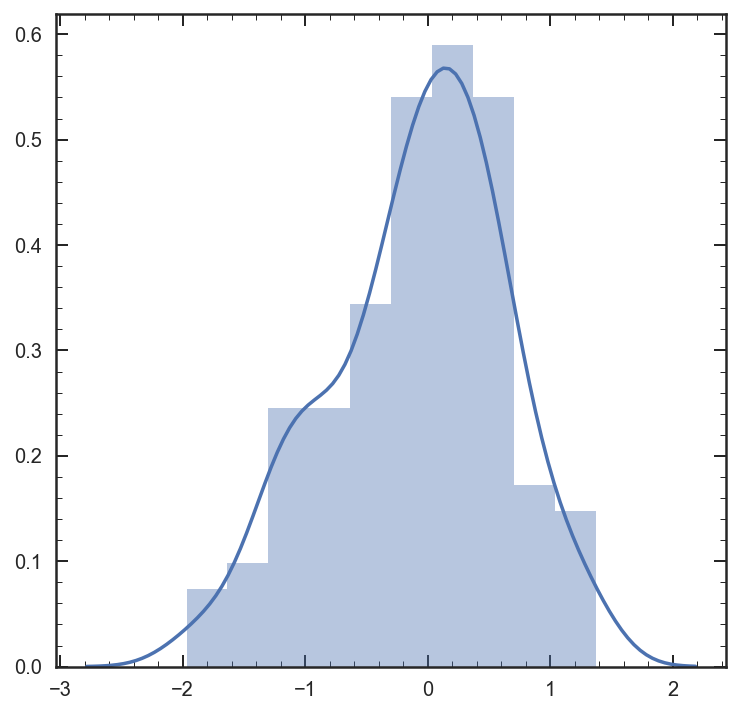

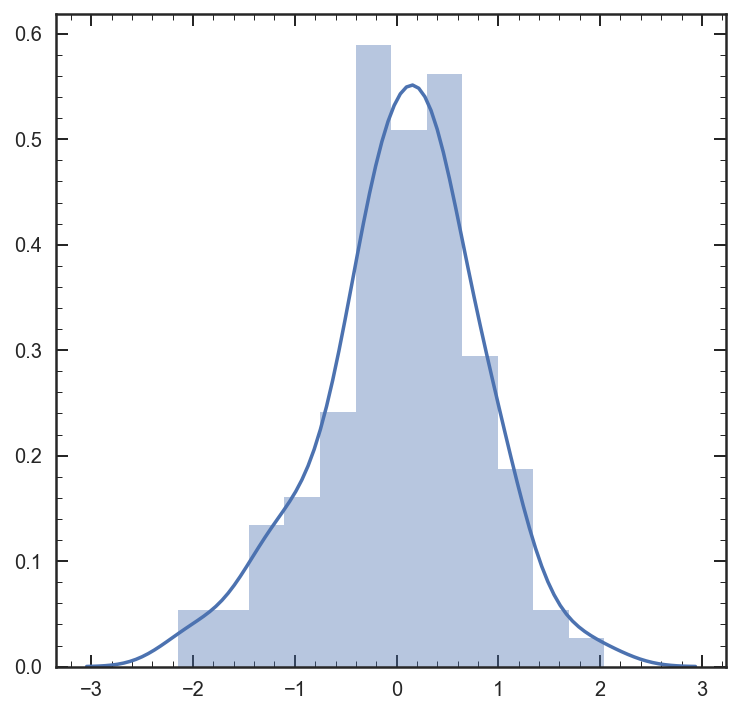

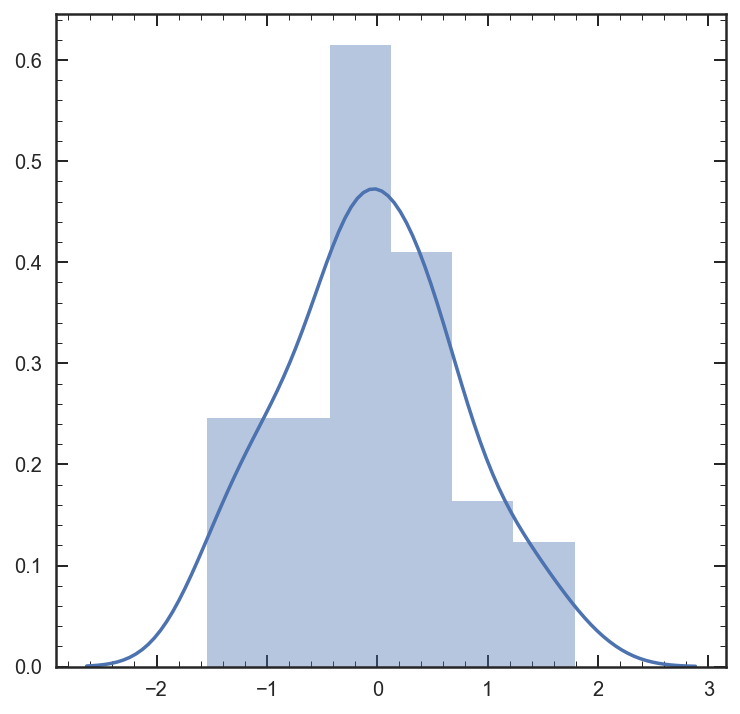

In [133]:
plt.figure(figsize=[6,6])
sea.distplot((sp1.Bflx - sp1.Bmfl)/sp1.Berr)

plt.figure(figsize=[6,6])
sea.distplot((sp1.Rflx - sp1.Rmfl)/sp1.Rerr)

plt.figure(figsize=[6,6])
sea.distplot((sp1.Pflx - sp1.Pmfl)/sp1.Perr)

(3, 4.698970004336019)

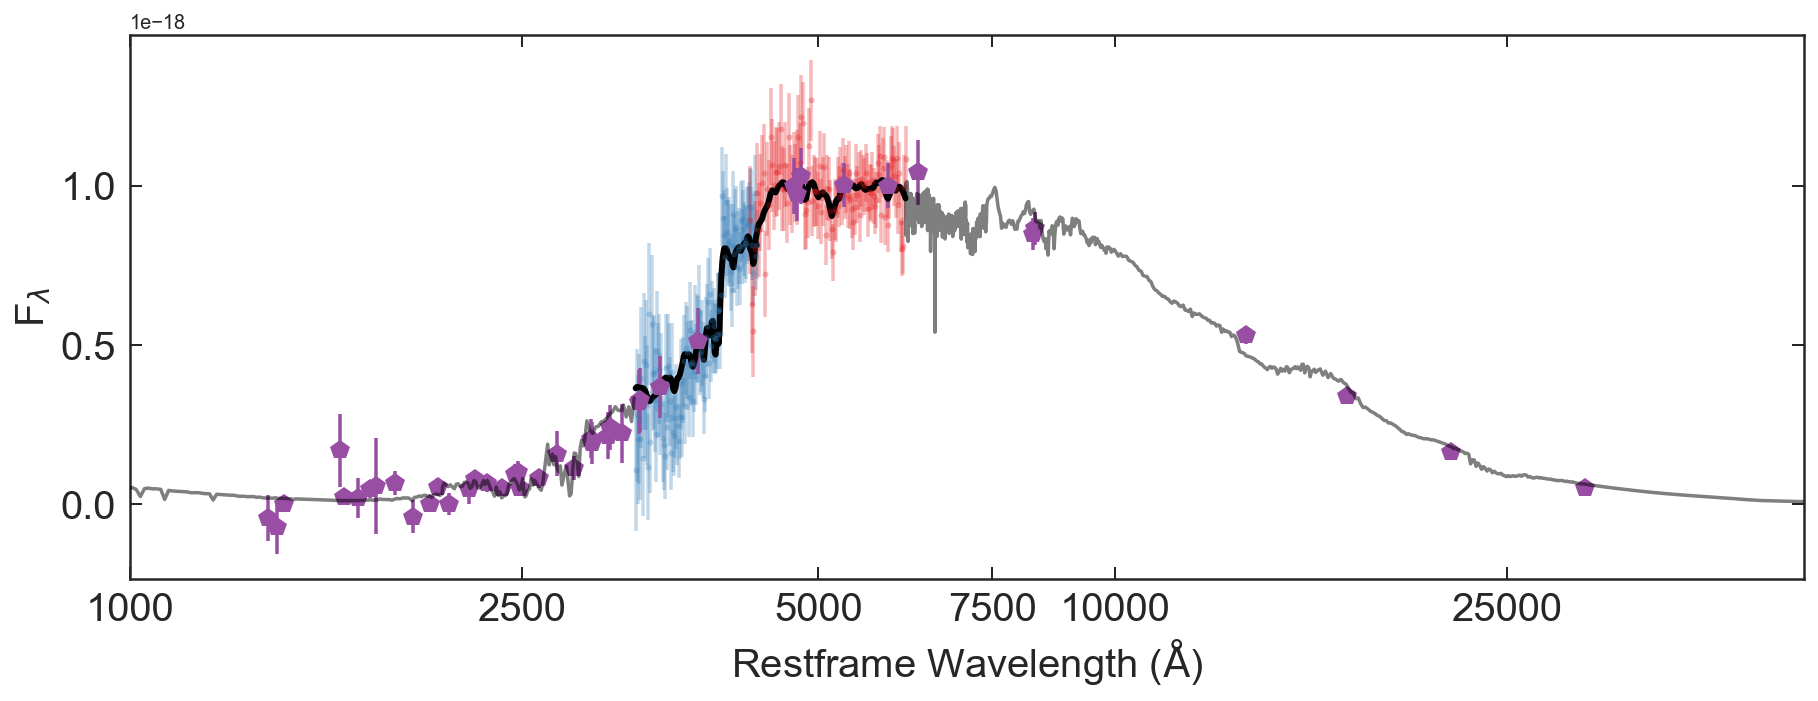

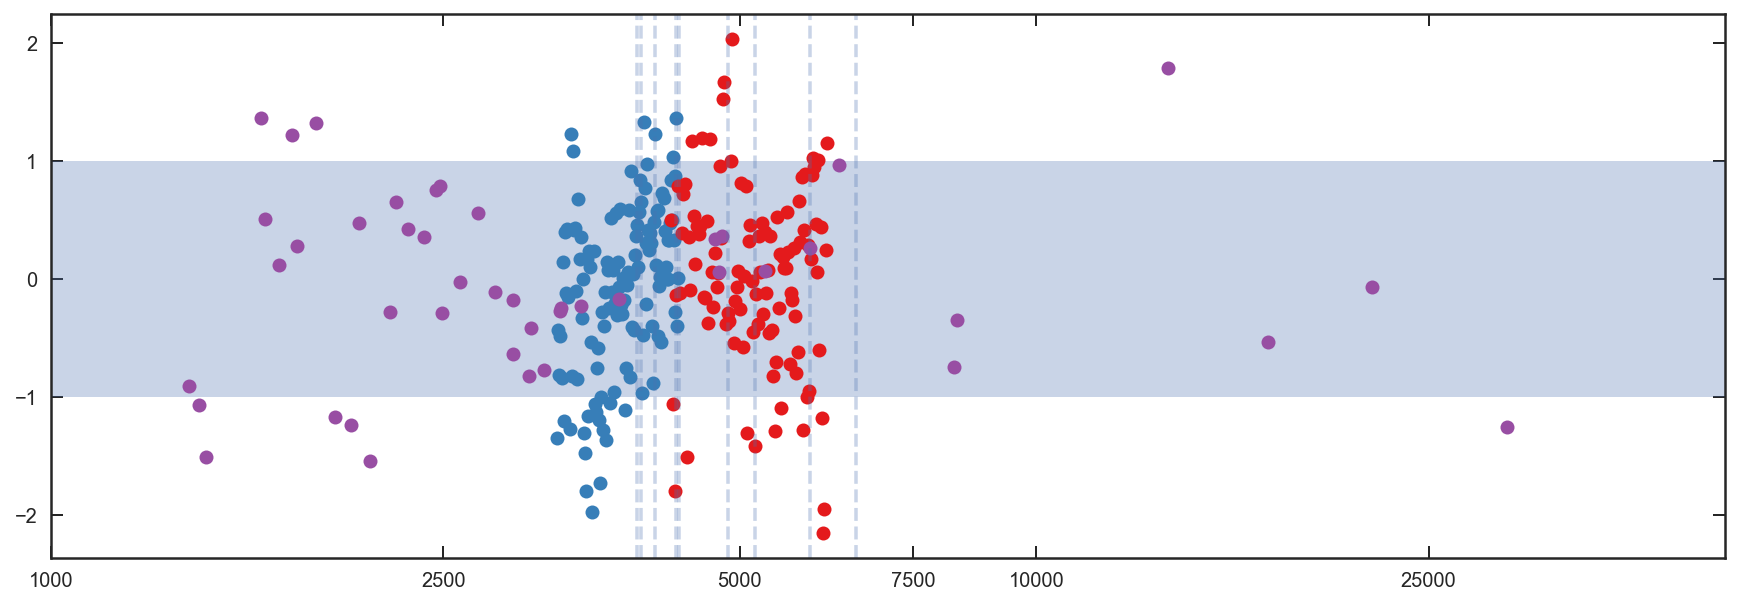

In [134]:
wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(0.024, 1.6, 0))
cal = Calzetti(0.1,wv)

plt.figure(figsize=[15,5])
plt.errorbar(np.log10(sp1.Bwv_rf),sp1.Bflx,sp1.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(sp1.Rwv_rf),sp1.Rflx,sp1.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

plt.errorbar(np.log10(sp1.Pwv_rf),sp1.Pflx,sp1.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')
plt.plot(np.log10(sp1.Bwv_rf),sp1.Bmfl,'k',linewidth=3)
plt.plot(np.log10(sp1.Rwv_rf),sp1.Rmfl,'k',linewidth=3)


IDb = [U for U in range(len(wv)) if wv[U] < sp1.Bwv_rf[0]]
IDr = [U for U in range(len(wv)) if wv[U] > sp1.Rwv_rf[-1]]

plt.plot(np.log10(wv[IDb]),sp1.PC * fl[IDb] * cal[IDb],'k',ms=10,zorder =5,alpha=0.5)
plt.plot(np.log10(wv[IDr]),sp1.PC * fl[IDr] * cal[IDr],'k',ms=10,zorder =5,alpha=0.5)

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

###

plt.figure(figsize=[15,5])
plt.plot(np.log10(sp1.Bwv_rf),(sp1.Bflx - sp1.Bmfl)/sp1.Berr,'o', color='#377eb8')
plt.plot(np.log10(sp1.Rwv_rf),(sp1.Rflx - sp1.Rmfl)/sp1.Rerr, 'o', color='#e41a1c')
plt.plot(np.log10(sp1.Pwv_rf),(sp1.Pflx - sp1.Pmfl)/sp1.Perr, 'o', color='#984ea3')
plt.axhspan(-1,1,alpha=0.3)

plt.axvline(np.log10(3934.777),linestyle='--', alpha=.3)
plt.axvline(np.log10(3969.588),linestyle='--', alpha=.3)
plt.axvline(np.log10(4102.89),linestyle='--', alpha=.3)
plt.axvline(np.log10(4305.61),linestyle='--', alpha=.3)
plt.axvline(np.log10(4341.68),linestyle='--', alpha=.3)
plt.axvline(np.log10(4862.68),linestyle='--', alpha=.3)
plt.axvline(np.log10(5176.7),linestyle='--', alpha=.3)
plt.axvline(np.log10(5895.6),linestyle='--', alpha=.3)
plt.axvline(np.log10(6564),linestyle='--', alpha=.3)

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))

# try out fsps

In [9]:
def L_nu_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    lam_0 = lam / (1 + z) # restframe wavelenth in angstrom
    dust = 10**(-0.4*Av)
    return ((lam_0**2)/(c * m_star)) * l_aa * dust * 3.839E33

def F_nu_per_M(l_aa, lam, z, Av, m_star):
    conv = 3.086E24 # conversion of Mpc to cm
    D_l = cosmo.luminosity_distance(z).value # in Mpc
    return (1 + z) * L_nu_per_M(l_aa, lam, z, Av, m_star)  / (4 * np.pi * (D_l*conv)**2)

def F_lam_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    return (c / lam**2) * F_nu_per_M(l_aa, lam, z, Av, m_star)

def Get_mass(gwv, gfl, ger, Z, t, z, Av):
    sp = fsps.StellarPopulation(imf_type=1, tpagb_norm_type=0, zcontinuous=1, logzsol=np.log10(Z / 0.019), sfh=0)
    wave,flux=np.array(sp.get_spectrum(tage=t,peraa=True))
    
    fl_m = F_lam_per_M(flux, wave * (1 + z), z, Av, sp.stellar_mass)
    
    IDX = [U for U in range(len(gwv)) if 8000 < gwv[U] < 11300]
    return np.log10(Scale_model(gfl[IDX],ger[IDX],interp1d(wv,fl_m)(gwv[IDX])))

In [32]:
# if tau[ii]==0:
#     sp = fsps.StellarPopulation(imf_type=0,tpagb_norm_type=0,zcontinuous=1,logzsol=np.log10(metal[i]/0.019), sfh=0)
# else:
#     ultau=np.round(np.power(10,np.array(tau[ii])-9),2)
idx = 22

Gs = Gen_spec2(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0], g102_lims=[8000,11300],tmp_err=True, phot_errterm=0.03)

sp = fsps.StellarPopulation(imf_type=0,tpagb_norm_type=0,zcontinuous=1,logzsol=np.log10(0.019/0.019), sfh=4,tau=0.01)#,compute_light_ages = True)
sp_lwa = fsps.StellarPopulation(imf_type=0,tpagb_norm_type=0,zcontinuous=1,logzsol=np.log10(0.019/0.019), sfh=4,tau=0.01,compute_light_ages = True)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [28]:
def Chi_squared(D, M, sig):
    return np.sum(((D-M)/sig)**2)

def P(F,x):
    F = np.array(F).astype(np.float128)
    return np.exp(-np.array(F) / 2) / np.trapz(np.exp(-np.array(F) / 2),x)

upd_age = np.arange(0.1, 4, 0.05)
upd_metal = np.round(np.arange(0.002,0.0305,0.0005),4)
upd_tau = np.round(np.logspace(-2,0.3,22),3)
uM,uA=np.meshgrid(upd_metal,upd_age)

In [135]:
# lwa_grid = np.zeros([upd_metal.size,upd_age.size,upd_tau.size])
flx_grid = np.zeros([upd_metal.size,upd_age.size,upd_tau.size,wv.size])
for i in range(len(upd_metal)):
    sp.params['logzsol'] = np.log10(upd_metal[i]/0.019)
#     sp_lwa.params['logzsol'] = np.log10(upd_metal[i]/0.019)
    for ii in range(len(upd_age)):
        for iii in range(len(upd_tau)):
            sp.params['tau'] = upd_tau[iii]
#             sp_lwa.params['tau'] = upd_tau[iii]
            wv,fl=np.array(sp.get_spectrum(tage=upd_age[ii],peraa=True))
#             wv_lwa,lwa_spec=np.array(sp_lwa.get_spectrum(tage=upd_age[ii]))
#             lwa_grid[i][ii][iii] = interp1d(wv_lwa,lwa_spec)(4750)
#             flx_grid[i][ii][iii] = F_lam_per_M(fl,wv * (1 +1.608), 1.608, 0 ,sp.stellar_mass)
            flx_grid[i][ii][iii] = fl


In [46]:
# np.save('../data/upd_flux_grid',flx_grid)

In [47]:
# np.save('../data/upd_light_weight_scaling',lwa_grid)

In [15]:
chi_total = chi_g102 + chi_g141 +chi_phot

In [16]:
P_g102 = np.exp(-chi_g102/2) / np.trapz(np.trapz(np.exp(-chi_g102/2),upd_metal,axis=1),upd_age)
Pt_g102 = np.trapz(P_g102,upd_metal,axis=1)
PZ_g102 = np.trapz(P_g102.T,upd_age,axis=1)

P_g141 = np.exp(-chi_g141/2) / np.trapz(np.trapz(np.exp(-chi_g141/2),upd_metal,axis=1),upd_age)
Pt_g141 = np.trapz(P_g141,upd_metal,axis=1)
PZ_g141 = np.trapz(P_g141.T,upd_age,axis=1)

P_phot = np.exp(-chi_phot/2) / np.trapz(np.trapz(np.exp(-chi_phot/2),upd_metal,axis=1),upd_age)
Pt_phot = np.trapz(P_phot,upd_metal,axis=1)
PZ_phot = np.trapz(P_phot.T,upd_age,axis=1)

P_T = np.exp(-chi_total/2) / np.trapz(np.trapz(np.exp(-chi_total/2),upd_metal,axis=1),upd_age)
Pt_T = np.trapz(P_T,upd_metal,axis=1)
PZ_T = np.trapz(P_T.T,upd_age,axis=1)
onesig,twosig = Likelihood_contours(upd_age,upd_metal,P_T)
levels = np.array([twosig,onesig])


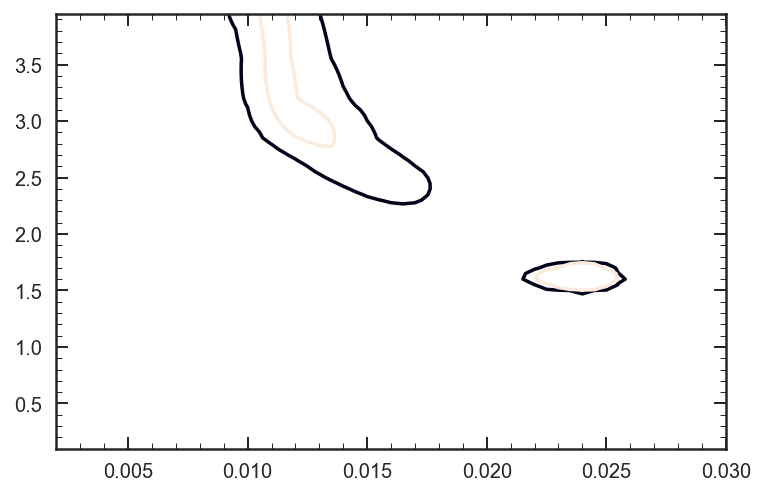

In [17]:
# plt.contour(uM,uA,np.exp(-chi_g102/2))
# plt.contour(uM,uA,np.exp(-chi_g141/2))
# plt.contour(uM,uA,np.exp(-chi_phot/2))
plt.contour(uM,uA,P_T,levels = levels)


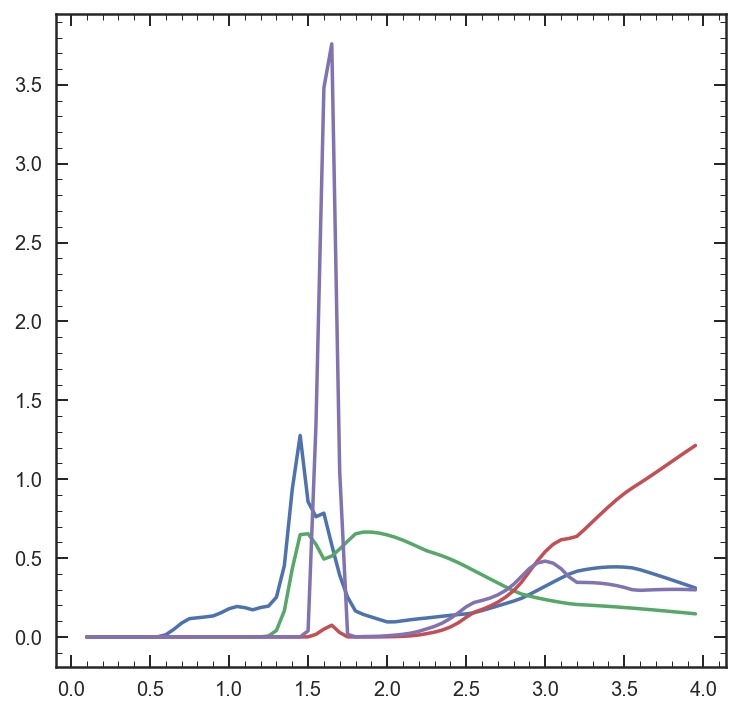

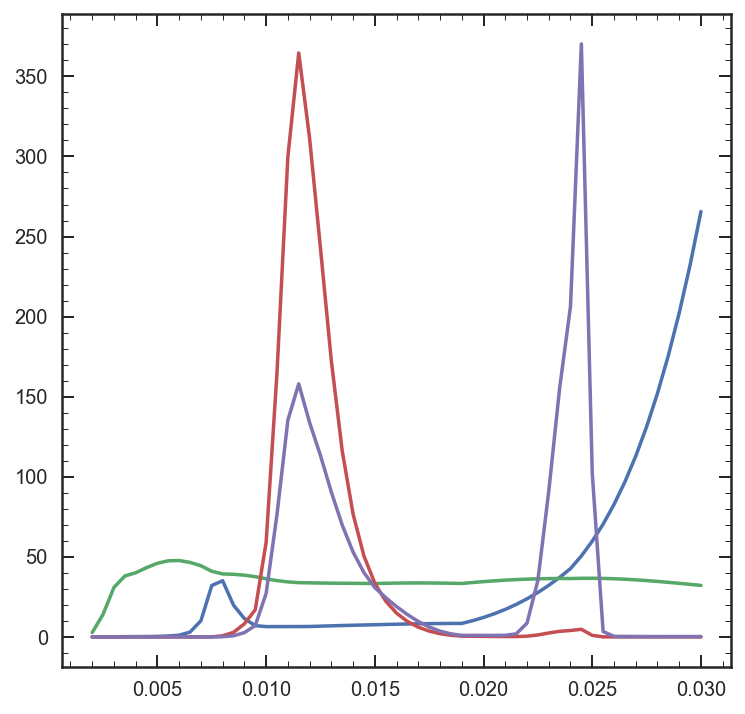

In [18]:
plt.figure(figsize=[6,6])
plt.plot(upd_age,Pt_g102)
plt.plot(upd_age,Pt_g141)
plt.plot(upd_age,Pt_phot)
plt.plot(upd_age,Pt_T)

plt.figure(figsize=[6,6])
plt.plot(upd_metal,PZ_g102)
plt.plot(upd_metal,PZ_g141)
plt.plot(upd_metal,PZ_phot)
plt.plot(upd_metal,PZ_T)

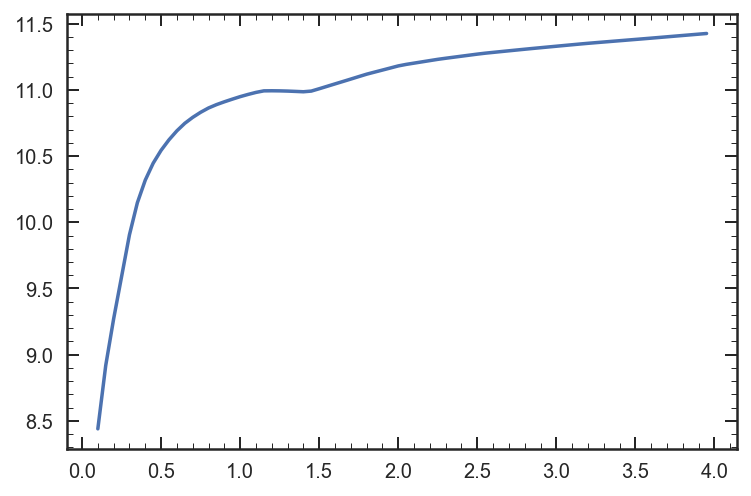

In [169]:
plt.plot(upd_age,M)

(3000, 5000)

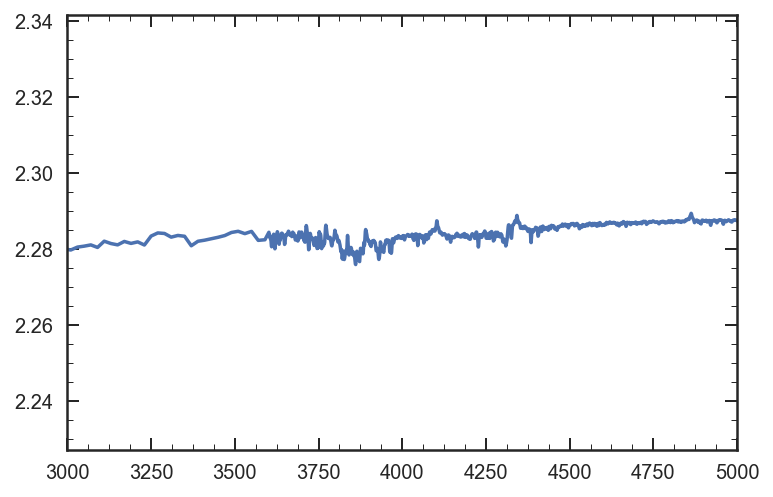

In [142]:
plt.plot(wv,fl)
plt.xlim(3000,5000)
# plt.ylim(0,1E2)

In [112]:
# flx_grid = np.zeros([metal.size,age.size,np.array(tau).size,wv.size])
# for i in range(len(metal)):
#     for ii in range(len(age)):
#         for iii in range(len(tau)):
#             wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(metal[i],age[ii],tau[iii]))
#             flx_grid[i][ii][iii] = fl

# flx_grid = np.load('../data/upd_flux_grid.npy')

Fit_all_test('GSD', 41520, glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0], 1.608, 
             flx_grid, upd_metal, upd_age, upd_tau, 'GSD_41520_upd_grid', 
            gen_models = False, age_conv= data_path + '../data/upd_light_weight_scaling.npy', errterm = 0.03,
           outname = 'none',fsps=True)

# flx_grid = []

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [111]:
from C_full_fit import Scale_model_mult

class Gen_spec2(object):
    def __init__(self, field, galaxy_id, specz, g102_beam, g141_beam,
                 g102_lims = [7900, 11300], g141_lims = [11100, 16000],
                 filter_102 = 201, filter_141 = 203, tmp_err = False, 
                 phot_errterm = 0):
        self.field = field
        self.galaxy_id = galaxy_id
        self.specz = specz
        self.c = 3E18          # speed of light angstrom s^-1
        self.g102_lims = g102_lims
        self.g141_lims = g141_lims
        
        """
        B - prefix refers to g102
        R - prefix refers to g141
        P - prefix refers to photometry
        
        field - GND/GSD/UDS
        galaxy_id - ID number from 3D-HST
        specz - z_grism
        g102_lims - window for g102
        g141_lims - window for g141
        tmp_err - (flag) whether or not we apply a template error function (not available)
        """
        self.Bwv, self.Bflx, self.Berr, self.Bflt = np.load(spec_path + '{0}_{1}_g102.npy'.format(field, galaxy_id))
        self.Rwv, self.Rflx, self.Rerr, self.Rflt = np.load(spec_path + '{0}_{1}_g141.npy'.format(field, galaxy_id))
        self.Bmask = np.load(spec_path + 'spec_mask/{0}_{1}_g102_mask.npy'.format(field, galaxy_id))
        self.Rmask = np.load(spec_path + 'spec_mask/{0}_{1}_g141_mask.npy'.format(field, galaxy_id))
        
        self.Bwv = self.Bwv[self.Bmask]
        self.Bflt = self.Bflt[self.Bmask]
        self.Bflx = self.Bflx[self.Bmask]
        self.Berr = self.Berr[self.Bmask] 
        
        self.Rwv = self.Rwv[self.Rmask]
        self.Rflt = self.Rflt[self.Rmask]
        self.Rflx = self.Rflx[self.Rmask]
        self.Rerr = self.Rerr[self.Rmask] 
        
        self.Pwv, self.Pflx, self.Perr, self.Pnum = np.load(phot_path + '{0}_{1}_phot.npy'.format(field, galaxy_id))
        self.Pwv_rf = self.Pwv / (1 + self.specz)
                
        self.IDB = [U for U in range(len(self.Bwv)) if g102_lims[0] <= self.Bwv[U] <= g102_lims[-1] and self.Bflx[U]**2 > 0]
        self.IDR = [U for U in range(len(self.Rwv)) if g141_lims[0] <= self.Rwv[U] <= g141_lims[-1] and self.Rflx[U]**2 > 0]

        self.Bwv = self.Bwv[self.IDB]
        self.Bwv_rf = self.Bwv / (1 + specz)
        self.Bflt = self.Bflt[self.IDB]
        self.Bflx = self.Bflx[self.IDB] 
        self.Berr = self.Berr[self.IDB] 
        
        self.Rwv = self.Rwv[self.IDR]
        self.Rwv_rf = self.Rwv / (1 + specz)
        self.Rflt = self.Rflt[self.IDR]
        self.Rflx = self.Rflx[self.IDR]
        self.Rerr = self.Rerr[self.IDR] 

        self.model_photDF = pd.read_pickle(phot_path + 'model_photometry_list.pkl')
        
        self.IDP = []
        for i in range(len(self.Pnum)):
            for ii in range(len(self.model_photDF)):
                if self.Pnum[i] == self.model_photDF.tmp_num[self.model_photDF.index[ii]]:
                    self.IDP.append(ii)
               
        if tmp_err:
            WV,TEF = np.load(template_path + 'template_error_test.npy')
            iTEF = interp1d(WV,TEF)(self.Bwv_rf)
            self.Berr = np.sqrt(self.Berr**2 + (iTEF*self.Bflx)**2)

            iTEF = interp1d(WV,TEF)(self.Rwv_rf)
            self.Rerr = np.sqrt(self.Rerr**2 + (iTEF*self.Rflx)**2)
            
            iTEF = interp1d(WV,TEF)(self.Pwv_rf)
            self.Perr = np.sqrt(self.Perr**2 + (iTEF * self.Pflx)**2+ (phot_errterm * self.Pflx)**2)
                
                
        self.Bbeam = model.BeamCutout(fits_file = g102_beam)
        self.Rbeam = model.BeamCutout(fits_file = g141_beam)

        #self.Bpoint_beam = model.BeamCutout(fits_file = '../beams/point_41086.g102.A.fits')
        #self.Rpoint_beam = model.BeamCutout(fits_file = '../beams/point_41086.g141.A.fits')
        
        ### Define precalculated terms for photometry
        self.sens_wv, self.trans = np.load(template_path + 'master_tmp.npy')
        self.b = np.load(template_path + 'bottom_precalc.npy')
        self.dnu = np.load(template_path + 'dnu_precalc.npy')
        self.adj = np.load(template_path + 'adj_precalc.npy')
        self.mdleffwv = np.load(template_path + 'effwv_precalc.npy') 
    
        ### Set transmission curve
        model_wave, model_flux = np.load(model_path + 'm0.019_a2.0_dt0_spec.npy')
        Bw,Bfl = self.Sim_spec_indv(self.Bbeam, model_wave, np.ones(len(model_wave)))
        Rw,Rfl = self.Sim_spec_indv(self.Rbeam, model_wave, np.ones(len(model_wave)))
        self.Btrans = interp1d(Bw,Bfl)(self.Bwv)       
        self.Rtrans = interp1d(Rw,Rfl)(self.Rwv) 
    
    def Sim_spec_indv(self, BEAM, model_wave, model_flux):
        ### creates a model using an individual beam
        BEAM.beam.compute_model(spectrum_1d=[model_wave, model_flux])
        w, f, e = BEAM.beam.optimal_extract(BEAM.beam.model, bin=0)
        return w, f
        
    def Sim_spec_mult(self, model_wave, model_flux):
        ### creates a model for g102 and g141 using individual beams
        return self.Sim_spec_indv(self.Bbeam, model_wave, model_flux), \
                self.Sim_spec_indv(self.Rbeam, model_wave, model_flux)

    def Sim_spec_mult_point(self, model_wave, model_flux):
        ### creates a model for g102 and g141 using individual beams
        return self.Sim_spec_indv(self.Bpoint_beam, model_wave, model_flux), \
                self.Sim_spec_indv(self.Rpoint_beam, model_wave, model_flux)
    
    def Sim_spec(self, metal, age, tau, model_redshift = 0, Av = 0, multi_component = False,
                point_scale=1):
        if model_redshift ==0:
            model_redshift = self.specz

        model_wave, model_flux = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(
            metal, age, tau))

        [Bmw, Bmf], [Rmw, Rmf] = self.Sim_spec_mult(model_wave * (1 + model_redshift), 
                                                                        model_flux * Calzetti(Av,model_wave))
        iBmf = interp1d(Bmw,Bmf)(self.Bwv)       
        iRmf = interp1d(Rmw,Rmf)(self.Rwv)     
        
        self.Bmfl = iBmf / self.Btrans
        self.Rmfl = iRmf / self.Rtrans
            
        self.Bmfl *= self.PC
        self.Rmfl *= self.PC
        
        Bscale = Scale_model(self.Bflx, self.Berr, self.Bmfl)
        Rscale = Scale_model(self.Rflx, self.Rerr, self.Rmfl)
        
        self.Bflx = self.Bflx / Bscale ; self.Berr = self.Berr / Bscale 
        self.Rflx = self.Rflx / Rscale ; self.Rerr = self.Rerr / Rscale 
        
        if multi_component:
            [Bpmw, Bpmf], [Rpmw, Rpmf] = self.Sim_spec_mult_point(model_wave * (1 + model_redshift), 
                                                                            model_flux * Calzetti(Av,model_wave))
            iBpmf = interp1d(Bpmw,Bpmf)(self.Bwv)       
            iRpmf = interp1d(Rpmw,Rpmf)(self.Rwv)     

            self.Bpmfl = iBpmf / self.Bflt
            self.Rpmfl = iRpmf / self.Rflt

            self.Bpmfl *= Scale_model(self.Bflx, self.Berr, self.Bpmfl)
            self.Rpmfl *= Scale_model(self.Rflx, self.Rerr, self.Rpmfl)
            
            self.Bpmfl *= point_scale
            self.Rpmfl *= point_scale
            
            self.BMCmfl = self.Bmfl + self.Bpmfl
            self.RMCmfl = self.Rmfl + self.Rpmfl
            
            self.BMCmfl *= Scale_model(self.Bflx, self.Berr, self.BMCmfl)
            self.RMCmfl *= Scale_model(self.Rflx, self.Rerr, self.RMCmfl)
       
    def Sim_phot_mult(self, model_wave, model_flux):
        
        imfl =interp1d(self.c / model_wave, (self.c/(self.c / model_wave)**2) * model_flux)

        mphot = (np.trapz(imfl(self.c /(self.sens_wv[self.IDP])).reshape([len(self.IDP),len(self.sens_wv[0])]) \
                          * self.b[self.IDP],self.dnu[self.IDP])/np.trapz(self.b[self.IDP],
                                                                          self.dnu[self.IDP])) * self.adj[self.IDP]
        
        return np.array([self.mdleffwv[self.IDP],mphot])

    def Sim_phot(self, metal, age, tau, model_redshift = 0, Av = 0):
        if model_redshift ==0:
            model_redshift = self.specz

        model_wave, model_flux = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(
            metal, age, tau))
        
        self.Pmwv, self.Pmfl = self.Sim_phot_mult(model_wave * (1 + model_redshift), 
                                                  model_flux * Calzetti(Av,model_wave))
        self.PC =  Scale_model(self.Pflx, self.Perr, self.Pmfl)  
        self.Pmfl = self.Pmfl * self.PC
        
    def Sim_all(self, metal, age, tau, model_redshift = 0, Av = 0):
        self.Sim_phot(metal, age, tau, model_redshift, Av)
        self.Sim_spec(metal, age, tau, model_redshift, Av)

    def Sim_all_test(self, model_wave, model_flux):
        self.Sim_phot_test(model_wave, model_flux)
        self.Sim_spec_test(model_wave, model_flux)
        
    def Sim_phot_test(self, model_wave, model_flux):

        self.Pmwv, self.Pmfl = self.Sim_phot_mult(model_wave, model_flux )
        self.PC =  Scale_model(self.Pflx, self.Perr, self.Pmfl)  
        self.Pmfl = self.Pmfl * self.PC
        
    def Sim_spec_test(self, model_wave, model_flux):

        [Bmw, Bmf], [Rmw, Rmf] = self.Sim_spec_mult(model_wave, model_flux)
        iBmf = interp1d(Bmw,Bmf)(self.Bwv)       
        iRmf = interp1d(Rmw,Rmf)(self.Rwv)     
        
        self.Bmfl = iBmf / self.Btrans
        self.Rmfl = iRmf / self.Rtrans
            
        self.Bmfl *= self.PC
        self.Rmfl *= self.PC
        
        Bscale = Scale_model(self.Bflx, self.Berr, self.Bmfl)
        Rscale = Scale_model(self.Rflx, self.Rerr, self.Rmfl)
        
        self.Bflx = self.Bflx / Bscale ; self.Berr = self.Berr / Bscale 
        self.Rflx = self.Rflx / Rscale ; self.Rerr = self.Rerr / Rscale 

#############
#############

####update starts here ########

def Gen_mflgrid_test(spec, name, flux_grid, metal, age, tau, specz):
    wv,fl = np.load(model_path + 'm0.019_a2.8_dt0_spec.npy')

    [Bmwv,Bmf_len], [Rmwv,Rmf_len] = spec.Sim_spec_mult(wv,fl)
    
    ##### set model wave
    Bmfl = np.zeros([len(metal)*len(age)*len(tau),len(Bmf_len)])
    Rmfl = np.zeros([len(metal)*len(age)*len(tau),len(Rmf_len)])
    Pmfl = np.zeros([len(metal)*len(age)*len(tau),len(spec.IDP)])
    
    for i in range(len(metal)):      
        for ii in range(len(age)):
            for iii in range(len(tau)):
                [Bmwv,Bmflx], [Rmwv,Rmflx] = spec.Sim_spec_mult(wv * (1 + specz), flux_grid[i][ii][iii])
                Pmwv, Pmflx = spec.Sim_phot_mult(wv * (1 + specz), flux_grid[i][ii][iii])

                Bmfl[i*len(age)*len(tau) + ii*len(tau) + iii] = Bmflx
                Rmfl[i*len(age)*len(tau) + ii*len(tau) + iii] = Rmflx
                Pmfl[i*len(age)*len(tau) + ii*len(tau) + iii] = Pmflx

    np.save(chi_path + 'spec_files/{0}_test_g102'.format(name),Bmfl)
    np.save(chi_path + 'spec_files/{0}_test_g141'.format(name),Rmfl)
    np.save(chi_path + 'spec_files/{0}_test_phot'.format(name),Pmfl)
    
def Fit_all_test(field, galaxy, g102_beam, g141_beam, specz, flux_grid, metal, age, tau, name, 
        gen_models = True, age_conv= data_path + 'light_weight_scaling_3.npy', errterm = 0,
           outname = 'none',fsps=False):
   
    if outname == 'none':
        outname = name
    ######## initialize spec
    sp = Gen_spec2(field, galaxy, specz, g102_beam, g141_beam, tmp_err = True, phot_errterm = errterm)
    
    if gen_models:
        Gen_mflgrid_test(sp, name, flux_grid, metal, age, tau, specz)

    ## set some variables
    wv,fl = np.load(model_path + 'm0.019_a2.0_dt8.0_spec.npy')
    [Bmwv,Bmflx], [Rmwv,Rmflx] = sp.Sim_spec_mult(wv,fl)
    
    resize_fit_test(sp.Pwv, sp.Pflx, sp.Perr, 'none', 'phot', name, sp.Pwv, 
                     metal, age, tau, outname, phot = True) 
    
    resize_fit_test(sp.Bwv, sp.Bflx, sp.Berr, sp.Btrans, 'g102', name, Bmwv, 
                     metal, age, tau, outname)
    resize_fit_test(sp.Rwv, sp.Rflx, sp.Rerr, sp.Rtrans, 'g141', name, Rmwv, 
                     metal, age, tau, outname)

    
    P, PZ, Pt, Ptau,= Analyze_full_fit_test(outname, metal, age, tau, specz, age_conv = age_conv,fsps = fsps)

    np.save(out_path + '{0}_tZ_pos'.format(outname),P)
    np.save(out_path + '{0}_Z_pos'.format(outname),[metal,PZ])
    np.save(out_path + '{0}_t_pos'.format(outname),[age,Pt])
    np.save(out_path + '{0}_tau_pos'.format(outname),[np.append(0, np.power(10, np.array(tau)[1:] - 9)),Ptau])

def Resize(fit_wv, fit_flat, mwv, mfl):
    mfl = np.ma.masked_invalid(mfl)
    mfl.data[mfl.mask] = 0
    mfl = interp2d(mwv,range(len(mfl.data)),mfl.data)(fit_wv,range(len(mfl.data)))
    return mfl / fit_flat
    
def resize_fit_test(fit_wv, fit_fl, fit_er, fit_flat, instrument, name, mwv, 
                     metal, age, tau, outname, phot=False):
    #############Read in spectra and stich spectra grid together#################
    mfl = np.load(chi_path + 'spec_files/{0}_test_{1}.npy'.format(name,instrument))
    
    if phot:
        fit_test(fit_wv, fit_fl, fit_er, mfl, metal, age, tau, instrument, name, outname,phot = True)  
    
    else:
        mfl = Resize(fit_wv, fit_flat, mwv, mfl)
        fit_test(fit_wv, fit_fl, fit_er, mfl, metal, age, tau, instrument, name, outname)  

def fit_test(fit_wv, fit_fl, fit_er, mfl, metal, age, tau, instrument, name, outname, phot = False):    
        
    if phot:
        SCL = Scale_model_mult(fit_fl,fit_er, mfl)
        mfl = np.array([SCL]).T*mfl
        chigrid = np.sum(((fit_fl - mfl) / fit_er) ** 2, axis=1).reshape([len(metal), len(age), len(tau)])
        np.save(chi_path + '{0}_test_phot_SCL'.format(outname), np.array([SCL]).T)

    else:
        SCL = np.load(chi_path + '{0}_test_phot_SCL.npy'.format(outname))
        mfl = SCL*mfl
        SCL2 = Scale_model_mult(fit_fl,fit_er,mfl)
        chigrid = np.sum(((fit_fl / np.array([SCL2]).T - mfl) / (fit_er / np.array([SCL2]).T)) ** 2, axis=1).reshape([len(metal), len(age), len(tau)])

    np.save(chi_path + '{0}_test_{1}_chidata'.format(outname, instrument),chigrid)

def Analyze_full_fit_test(outname, metal, age, tau, specz, age_conv=data_path + 'light_weight_scaling_3.npy',fsps = False):
    ####### Get maximum age
    max_age = Oldest_galaxy(specz)
    
    ####### Read in file   
    chi = np.zeros([len(metal),len(age),len(tau)])
    instr = ['g102','g141','phot']
    
    for i in instr:
        chi_indv = np.load(chi_path + '{0}_test_{1}_chidata.npy'.format(outname, i))
        chi += chi_indv
    
    chi[: , len(age[age <= max_age]):] = 1E5

    if fsps:
        scl = np.log10(np.load(chi_path + '{0}_test_phot_SCL.npy'.format(outname)))
        scl = scl.reshape([len(metal), len(age), len(tau)])
        chi[scl < 10.5] = 1E5
        chi[scl > 11.5] = 1E5
    
    ####### Get scaling factor for tau reshaping
    convtable = np.load(age_conv)
    
    if fsps:
        ultau = tau
        
    else:
        ultau = np.append(0, np.power(10, np.array(tau)[1:] - 9))
    
    overhead = np.zeros([len(tau),metal.size]).astype(int)
    for i in range(len(tau)):
        for ii in range(metal.size):
            amt=[]
            for iii in range(age.size):
                if age[iii] > convtable.T[i].T[ii][-1]:
                    amt.append(1)
            overhead[i][ii] = sum(amt)

    ######## get Pd and Pz 
    P = np.exp(- chi / 2).astype(np.float128)

    new_P = np.zeros(P.T.shape)

    ######## Reshape likelihood to get light weighted age instead of age when marginalized
    for i in range(len(tau)):
        frame = np.zeros([metal.size,age.size])
        for ii in range(metal.size):
            dist = interp1d(convtable.T[i].T[ii],P.T[i].T[ii])(age[:-overhead[i][ii]])
            frame[ii] = np.append(dist,np.repeat(0, overhead[i][ii]))
        new_P[i] = frame.T

    ####### Create normalize probablity marginalized over tau
    P = new_P.T

    # test_prob = np.trapz(test_P, ultau, axis=2)
    C = np.trapz(np.trapz(np.trapz(P, ultau, axis=2), age, axis=1), metal)

    P /= C

    prob = np.trapz(P, ultau, axis=2)
    
    # #### Get Z, t, tau, and z posteriors
    PZ = np.trapz(np.trapz(P, ultau, axis=2), age, axis=1)
    Pt = np.trapz(np.trapz(P, ultau, axis=2).T, metal, axis=1)
    Ptau = np.trapz(np.trapz(P.T, metal, axis=2), age, axis=1)

    return prob.T, PZ, Pt, Ptau

In [115]:
Zr, PrZ = np.load('../data/posteriors/GSD_41520_reg_grid_Z_pos.npy')
Zu, PuZ = np.load('../data/posteriors/GSD_41520_upd_grid_Z_pos.npy')

tr, Prt = np.load('../data/posteriors/GSD_41520_reg_grid_t_pos.npy')
tu, Put = np.load('../data/posteriors/GSD_41520_upd_grid_t_pos.npy')

taur, Prtau = np.load('../data/posteriors/GSD_41520_reg_grid_tau_pos.npy')
tauu, Putau = np.load('../data/posteriors/GSD_41520_upd_grid_tau_pos.npy')

Pr = np.load('../data/posteriors/GSD_41520_reg_grid_tZ_pos.npy')
Pu = np.load('../data/posteriors/GSD_41520_upd_grid_tZ_pos.npy')

onesig,twosig = Likelihood_contours(age,metal,Pr)
levels_r = np.array([twosig,onesig])

onesig,twosig = Likelihood_contours(upd_age, upd_metal,Pu)
levels_u= np.array([twosig,onesig])

(0, 4)

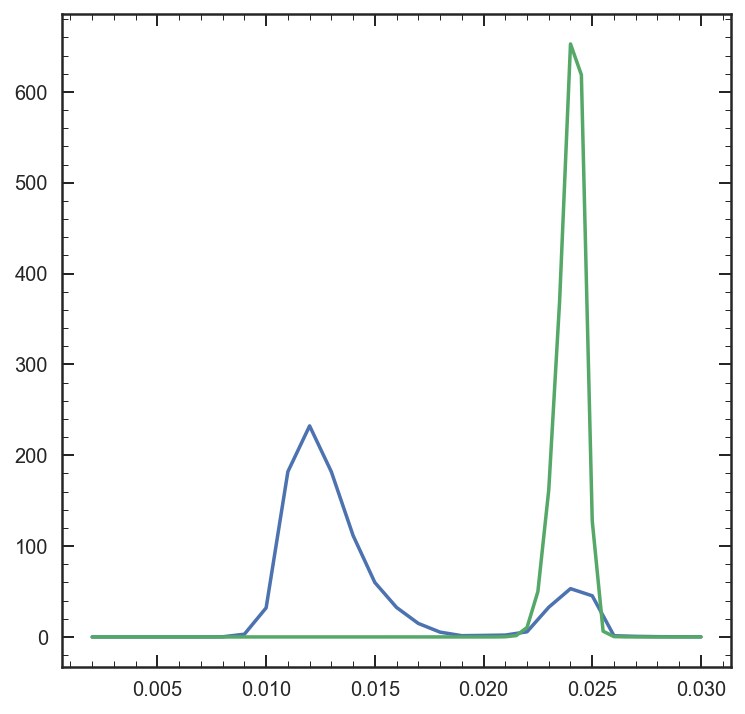

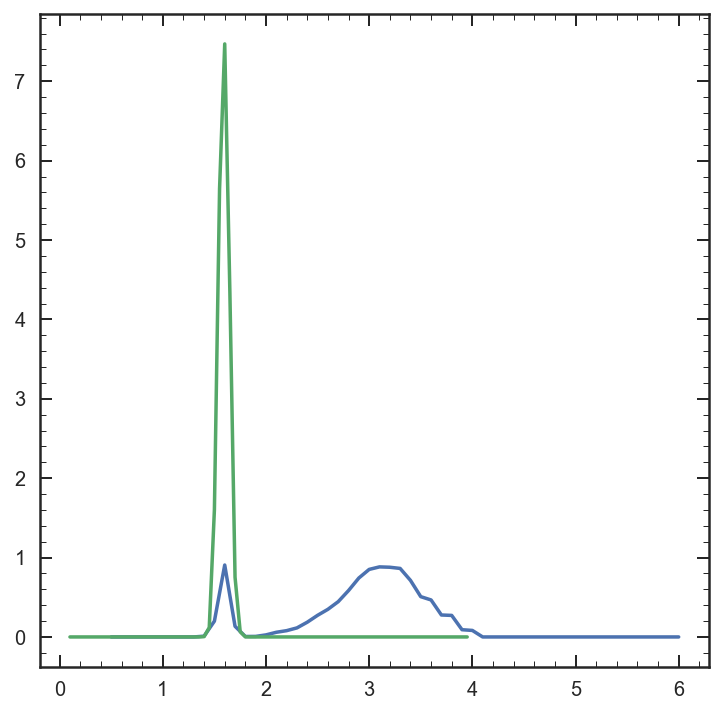

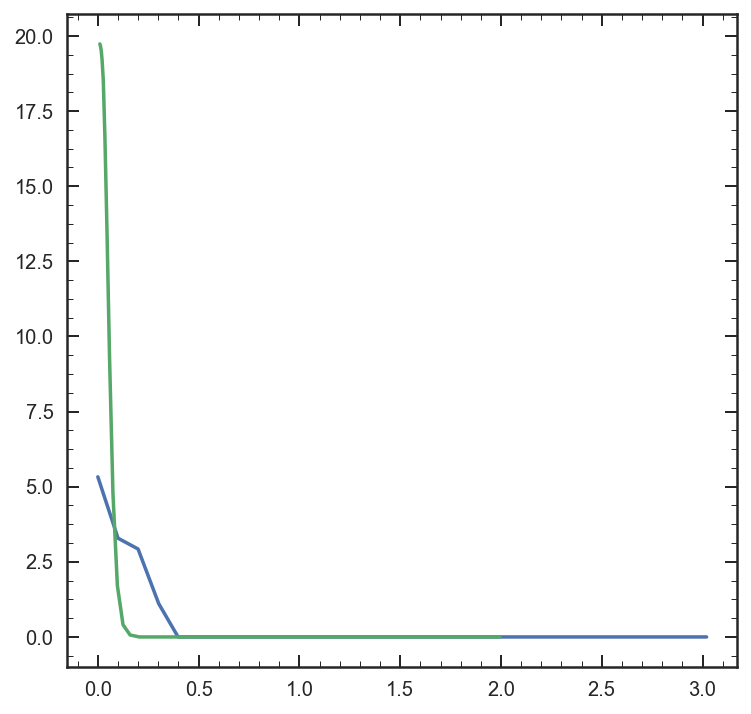

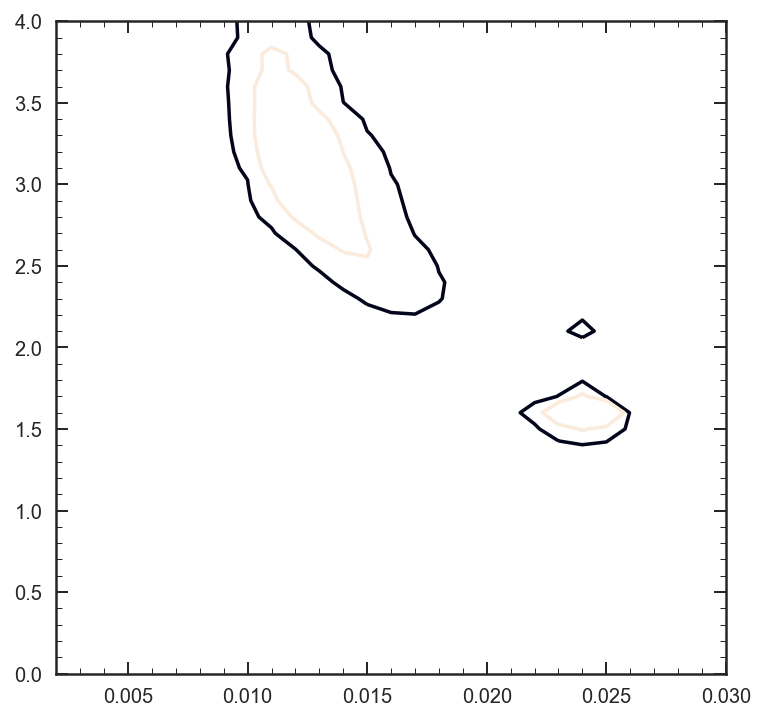

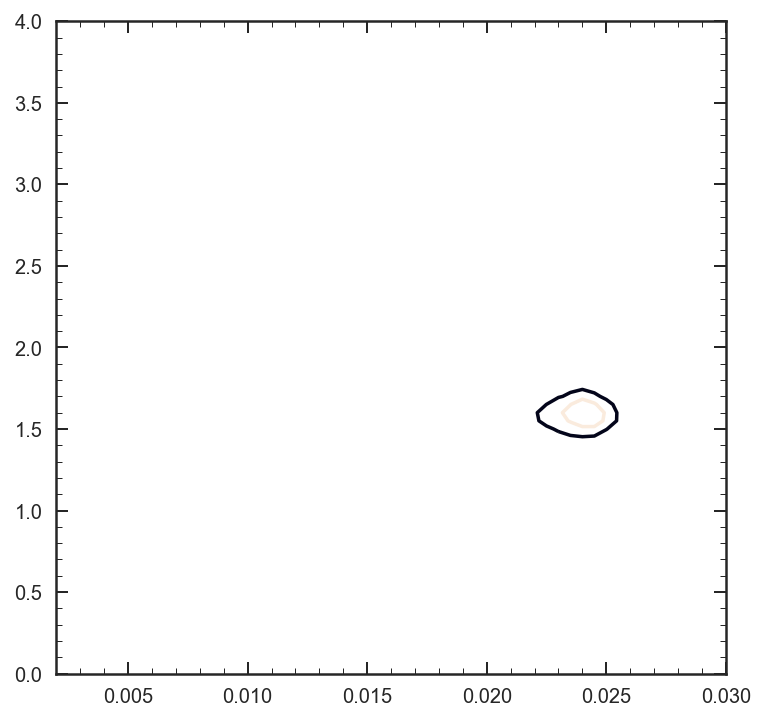

In [116]:
plt.figure(figsize=[6,6])
plt.plot(Zr,PrZ)
plt.plot(Zu,PuZ)

plt.figure(figsize=[6,6])
plt.plot(tr,Prt)
plt.plot(tu,Put)

plt.figure(figsize=[6,6])
plt.plot(taur,Prtau)
plt.plot(upd_tau,Putau)

plt.figure(figsize=[6,6])
plt.contour(M,A,Pr,levels_r)
plt.ylim(0,4)

plt.figure(figsize=[6,6])
plt.contour(uM,uA,Pu,levels_u)
plt.ylim(0,4)


In [86]:
scl = np.load('../chidat/GSD_41520_upd_grid_test_phot_SCL.npy')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


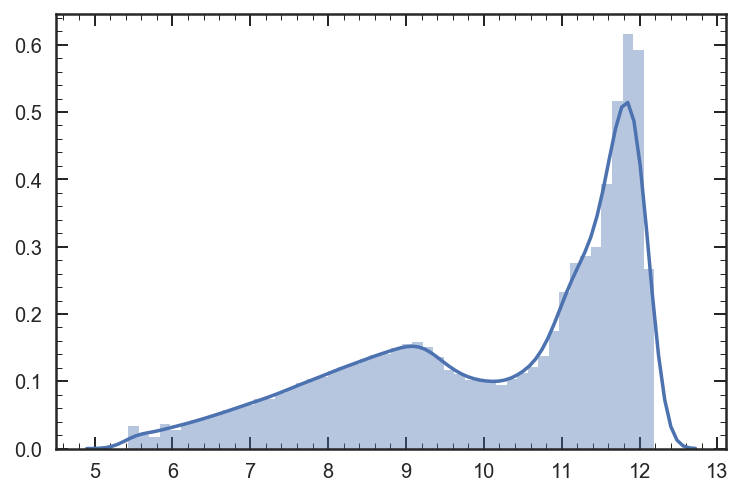

In [88]:
sea.distplot(np.log10(scl))

# create mult mass

In [7]:
flx_grid = np.zeros([2,2,2,len(wv)])
for i in range(2):
    for ii in range(2):
        for iii in range(2):
            wv,fl = np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(metal[i], age[ii], tau[iii]))
            flx_grid[i][ii][iii] = fl

In [8]:
flx_grid

array([[[[7.64102815e-06, 7.20072267e-06, 8.78241105e-06, ...,
          1.56140708e-19, 1.50422772e-19, 1.44886055e-19],
         [2.70262316e-06, 2.54683882e-06, 3.10641958e-06, ...,
          2.12453106e-19, 2.04343391e-19, 1.96845160e-19]],

        [[2.57639731e-07, 2.44375057e-07, 2.91665981e-07, ...,
          1.22892772e-19, 1.18414879e-19, 1.14104643e-19],
         [3.68838292e-06, 3.47575326e-06, 4.23868503e-06, ...,
          1.89940883e-19, 1.82801465e-19, 1.76100690e-19]]],


       [[[7.20024735e-06, 6.78346190e-06, 8.27503276e-06, ...,
          1.67537186e-19, 1.61378237e-19, 1.55497972e-19],
         [2.19694828e-06, 2.07025971e-06, 2.52515733e-06, ...,
          2.08308526e-19, 2.00439489e-19, 1.93064840e-19]],

        [[3.85919422e-06, 3.63883687e-06, 4.43285564e-06, ...,
          1.28133342e-19, 1.23456463e-19, 1.18959898e-19],
         [4.44973883e-06, 4.19304212e-06, 5.11414307e-06, ...,
          1.92188716e-19, 1.85007559e-19, 1.78228477e-19]]]])

In [10]:
F_lam_per_M(wv*(1+1.608), flx_grid, 1.608,0,0.75)

array([[[[2.61700542e-23, 2.70328032e-23, 2.76079693e-23, ...,
          2.82320244e-17, 2.84937249e-17, 2.87583013e-17],
         [2.61700542e-23, 2.70328032e-23, 2.76079693e-23, ...,
          2.82320244e-17, 2.84937249e-17, 2.87583013e-17]],

        [[2.61700542e-23, 2.70328032e-23, 2.76079693e-23, ...,
          2.82320244e-17, 2.84937249e-17, 2.87583013e-17],
         [2.61700542e-23, 2.70328032e-23, 2.76079693e-23, ...,
          2.82320244e-17, 2.84937249e-17, 2.87583013e-17]]],


       [[[2.61700542e-23, 2.70328032e-23, 2.76079693e-23, ...,
          2.82320244e-17, 2.84937249e-17, 2.87583013e-17],
         [2.61700542e-23, 2.70328032e-23, 2.76079693e-23, ...,
          2.82320244e-17, 2.84937249e-17, 2.87583013e-17]],

        [[2.61700542e-23, 2.70328032e-23, 2.76079693e-23, ...,
          2.82320244e-17, 2.84937249e-17, 2.87583013e-17],
         [2.61700542e-23, 2.70328032e-23, 2.76079693e-23, ...,
          2.82320244e-17, 2.84937249e-17, 2.87583013e-17]]]])

In [15]:
%%timeit

F_lam_per_M(wv*(1+1.608), np.ones(len(wv)), 1.608, 0, 0.75) 

500 µs ± 35.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
500E-6 *

0.0005

In [14]:
flx_grid

array([[[[1.99966121e-28, 1.94655719e-28, 2.42464534e-28, ...,
          4.40816827e-36, 4.28610510e-36, 4.16667681e-36],
         [7.07277946e-29, 6.88481928e-29, 8.57619362e-29, ...,
          5.99798127e-36, 5.82250439e-36, 5.66093244e-36]],

        [[6.74244573e-30, 6.60614284e-30, 8.05230542e-30, ...,
          3.46951174e-36, 3.37408100e-36, 3.28145572e-36],
         [9.65251810e-29, 9.39593541e-29, 1.17021486e-28, ...,
          5.36241564e-36, 5.20869467e-36, 5.06435670e-36]]],


       [[[1.88430863e-28, 1.83375991e-28, 2.28456850e-28, ...,
          4.72991391e-36, 4.59826709e-36, 4.47185754e-36],
         [5.74942555e-29, 5.59649234e-29, 6.97144658e-29, ...,
          5.88097138e-36, 5.71126765e-36, 5.55221684e-36]],

        [[1.00995322e-28, 9.83679611e-29, 1.22382142e-28, ...,
          3.61746363e-36, 3.51773449e-36, 3.42108459e-36],
         [1.16449906e-28, 1.13349683e-28, 1.41191105e-28, ...,
          5.42587651e-36, 5.27155450e-36, 5.12554823e-36]]]])